# Hate speech detection

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from time import perf_counter
from collections import Counter
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import voyageai
import optuna
import re
from skimpy import skim
import emoji
import math
import re
import nltk
from wordcloud import WordCloud
import gensim.downloader as api
import fasttext
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
tqdm.pandas()

In [ ]:
nltk.download('stopwords')
wv = api.load('glove-twitter-50')

[nltk_data] Downloading package stopwords to /home/ilan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## helpfunctions for download embeddings

In [ ]:
def download_csv(df : pd.DataFrame, filename : str) -> None:
    """
    Download a DataFrame as a CSV file.
    :param df: The DataFrame to download.
    :param filename: The filename to save the CSV file as.
    """
    def vector_to_json(v):
        """
        Convert a vector to a JSON string.
        :param v: The vector to convert.
        """
        if not isinstance(v, list):
            v = v.tolist()
        return json.dumps(v)

    df_tmp = df.copy()
    df_tmp['GloVe'] = df_tmp['GloVe'].apply(vector_to_json)
    df_tmp['FastText'] = df_tmp['FastText'].apply(vector_to_json)
    df_tmp['Voyage'] = df_tmp['Voyage'].apply(vector_to_json)

    df_tmp.to_csv(filename, index=False)

def load_csv(filename : str) -> pd.DataFrame:
    """
    Load a CSV file as a DataFrame.
    :param filename: The filename to load.
    """
    def json_to_vector(j):
        """
        Convert a JSON string to a vector.
        :param j: The JSON string to convert.
        """
        return np.array(json.loads(j))

    df_tmp = pd.read_csv(filename)
    df_tmp['GloVe'] = df_tmp['GloVe'].apply(json_to_vector)
    df_tmp['FastText'] = df_tmp['FastText'].apply(json_to_vector)
    df_tmp['Voyage'] = df_tmp['Voyage'].apply(json_to_vector)

    return df_tmp

# 1. Cleaning and visualizations

## We have a dataset of 700,000 rows, but due to time and resource constraints, I unfortunately cannot use all of this data. Therefore, we need to estimate how much data to retrieve. To do this, we will use **Hoeffding's inequality** with a tolerated error of 0.01 and a confidence level of 0.01 (which is equivalent to 99%)

## **$$ P(|\hat{p} - p| > \epsilon) \leq 2e^{-2N\epsilon^2} $$**

In [ ]:
def calculate_hoeffding_samples(epsilon : float, delta : float) -> int:
    """
    Calculate the minimum number of samples required based on Hoeffding's Inequality.

    :param epsilon: The tolerance level (a small positive number).
    :param delta: The probability threshold for the confidence level.
    :return: The minimum number of samples required.
    """
    n = math.ceil(math.log(2/delta) / (2 * epsilon**2))
    return n

epsilon = 0.01
delta = 0.01
n_samples = calculate_hoeffding_samples(epsilon, delta)
print(f'Minimum number of samples required: {n_samples}')


Minimum number of samples required: 26492


## We will therefore cap this value at **30,000** and retrieve a balanced sample (which means stratified in our case since the original dataset is already stratified) to work with

In [ ]:
df = pd.read_csv('HateSpeechDatasetBalanced.csv')
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [ ]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 726119 │ │ string      │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %    ┃ mean    ┃ sd     ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ Label              │    0 │       0 │     0.5 │    0.5 │    0 │     0 │     1 │     1 │       1 │  ▇    ▇  │  │
│ └────────────────────┴──────┴─────────┴─────────┴────────┴──────┴───────┴───────┴───────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Content                   │       0 │          0 │                           36 │                 26383926 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

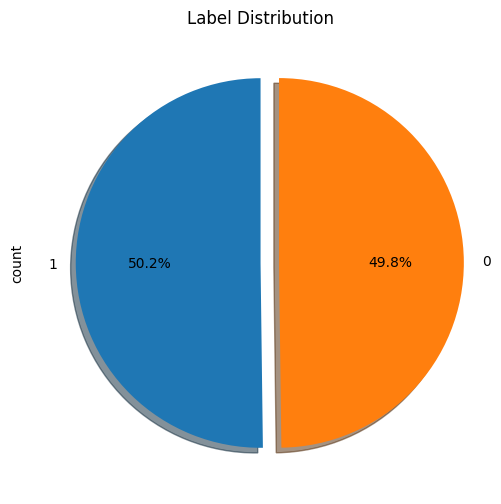

In [ ]:
plt.figure(figsize=(6, 6))
df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, explode=(0, 0.1), startangle=90)
plt.title('Label Distribution')
#plt.savefig('images/label_distribution_pie.png')
plt.show()

## As announced, we do indeed have a balanced dataset, and therefore we can retrieve a stratified sample of 30,000 data points

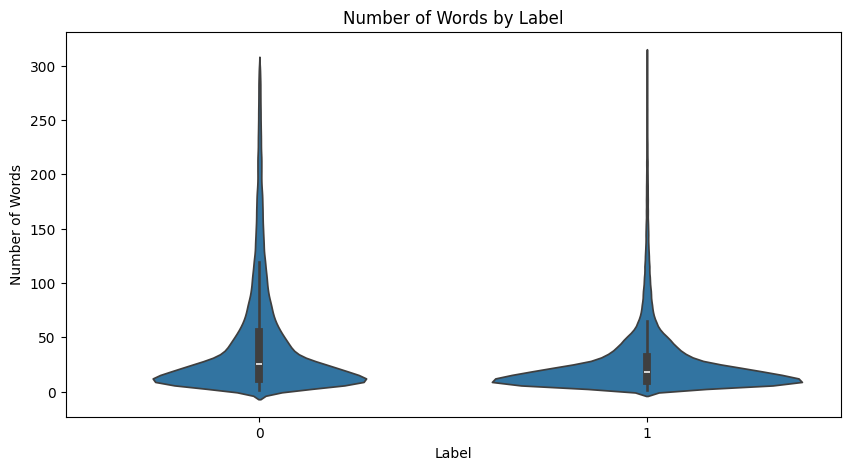

In [ ]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x='Label', y=df['Content'].apply(lambda x: len(x.split())))
plt.title('Number of Words by Label')
plt.xlabel('Label')
plt.ylabel('Number of Words')
#plt.savefig('images/word_count.png')
plt.show()

## The figure above shows us that most of our texts have a character count between 10 and 50. This visualization will be useful later when we need to choose a padding and truncation strategy

In [ ]:
df_train, df_test = train_test_split(df, train_size=30000, stratify=df['Label'], random_state=42)
df_test, df_val = train_test_split(df_test, train_size=10000,test_size=10000, stratify=df_test['Label'], random_state=42)
df_train.to_csv('data_train.csv', index=False)
df_test.to_csv('data_test.csv', index=False)
df_val.to_csv('data_val.csv', index=False)

In [ ]:
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')
df_val = pd.read_csv('data_val.csv')

In [ ]:
df_train.isna().sum()

Content    0
Label      0
dtype: int64

In [ ]:
def clean_text(text : str) -> str:
    """
    Clean the text by removing emojis, links, and special characters. Also, convert the text to lowercase,
    remove stop words, and stem the words.
    :param text: The text to clean.
    """

    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()


    words = text.split()

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]

    cleaned_text = ' '.join(words)

    return cleaned_text

In [ ]:
print('Cleaning text...')
print('Cleaning train set...')
df_train['Content'] = df_train['Content'].progress_apply(lambda x: clean_text(x))
print('Cleaning test set...')
df_test['Content'] = df_test['Content'].progress_apply(lambda x: clean_text(x))
print('Cleaning validation set...')
df_val['Content'] = df_val['Content'].progress_apply(lambda x: clean_text(x))
print('Done!')

Cleaning text...
Cleaning train set...


100%|██████████| 30000/30000 [00:18<00:00, 1647.40it/s]


Cleaning test set...


100%|██████████| 10000/10000 [00:06<00:00, 1621.92it/s]


Cleaning validation set...


100%|██████████| 10000/10000 [00:06<00:00, 1583.63it/s]

Done!


In [ ]:
df_train = df_train[~ (df_train['Content'] == '')]
df_test = df_test[~ (df_test['Content'] == '')]
df_val = df_val[~ (df_val['Content'] == '')]


In [ ]:
df_train.to_csv('data_train_cleaned.csv', index=False)
df_test.to_csv('data_test_cleaned.csv', index=False)
df_val.to_csv('data_val_cleaned.csv', index=False)

In [ ]:
df_train = pd.read_csv('data_train_cleaned.csv')
df_test = pd.read_csv('data_test_cleaned.csv')
df_val = pd.read_csv('data_val_cleaned.csv')

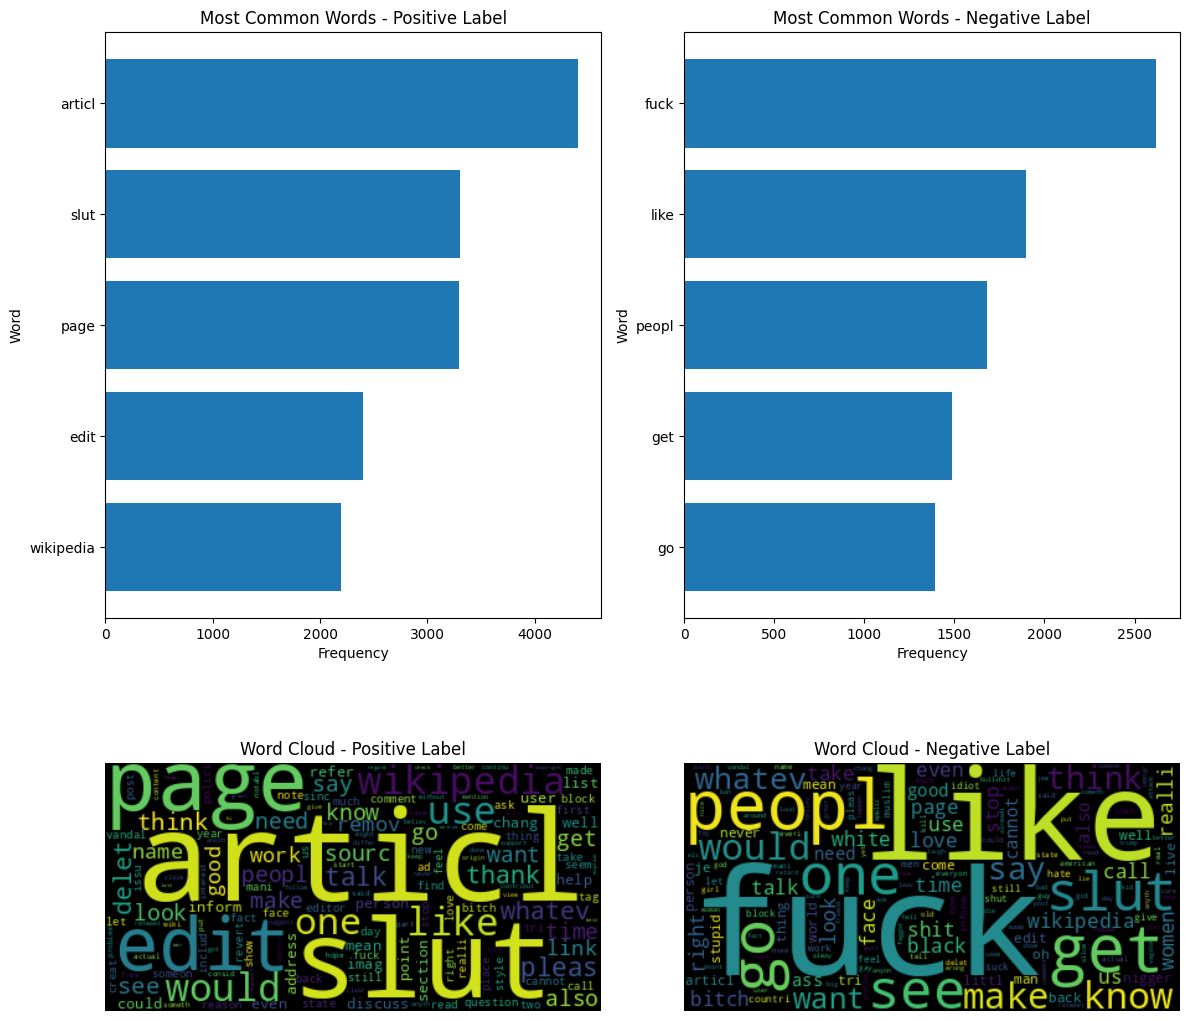

In [ ]:
counter_positive = Counter(df_train[df_train['Label'] == 0]['Content'].str.split().sum())
counter_negative = Counter(df_train[df_train['Label'] == 1]['Content'].str.split().sum())

most_common_positive = counter_positive.most_common(5)[::-1]
most_common_negative = counter_negative.most_common(5)[::-1]

words_positive, frequencies_positive = zip(*most_common_positive)
words_negative, frequencies_negative = zip(*most_common_negative)

word_freq_positive = dict(counter_positive)
word_freq_negative = dict(counter_negative)

wordcloud_positive = WordCloud(background_color='black').generate_from_frequencies(word_freq_positive)
wordcloud_negative = WordCloud(background_color='black').generate_from_frequencies(word_freq_negative)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].barh(words_positive, frequencies_positive)
axs[0, 0].set_title('Most Common Words - Positive Label')
axs[0, 0].set_xlabel('Frequency')
axs[0, 0].set_ylabel('Word')

axs[0, 1].barh(words_negative, frequencies_negative)
axs[0, 1].set_title('Most Common Words - Negative Label')
axs[0, 1].set_xlabel('Frequency')
axs[0, 1].set_ylabel('Word')

axs[1, 0].imshow(wordcloud_positive, interpolation='bilinear')
axs[1, 0].set_title('Word Cloud - Positive Label')
axs[1, 0].axis('off')

axs[1, 1].imshow(wordcloud_negative, interpolation='bilinear')
axs[1, 1].set_title('Word Cloud - Negative Label')
axs[1, 1].axis('off')

# plt.savefig('images/wordcloud.png')
plt.tight_layout()
plt.show()

## The figure above shows us the most frequent words according to the label. Indeed, for negative messages, we can see an insult that is significantly more prevalent

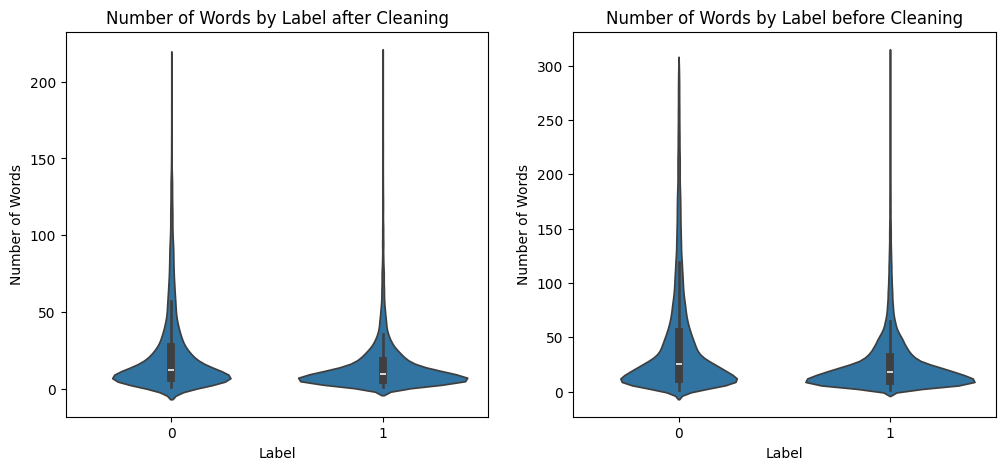

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.violinplot(data=df_train, x='Label', y=df_train['Content'].apply(lambda x: len(x.split())), ax=axs[0])
axs[0].set_title('Number of Words by Label after Cleaning')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Number of Words')

sns.violinplot(data=df, x='Label', y=df['Content'].apply(lambda x: len(x.split())), ax=axs[1])
axs[1].set_title('Number of Words by Label before Cleaning')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Number of Words')

#plt.savefig('images/word_count_cleaned_vs_non_cleaned.png')
plt.show()

## The figure above compares the distribution of the number of words for each label. We inevitably gain a few words, but the distributions remain very similar

## Now we will test different methods of embedding our texts:
### 1. TF-IDF
### 2. GloVe
### 3. fasttext
### 4. Transformer (Voyage-02)

In [ ]:
tfidf = TfidfVectorizer(max_features=10000)
vo = voyageai.Client(api_key = "pa-xsorIkepXUrYmSRizvQC6S9_y2mhAGALNUJCaqpe0JA")

def tokenize(text):
    return [token for token in text.split()]

def vectorize_with_gloVe(text):
  vector_size = wv.vector_size
  wv_res = np.zeros(vector_size)
  cpt = 1
  for w in text:
    if w in wv:
      cpt+=1
      wv_res += wv[w]
  wv_res = wv_res/cpt
  return wv_res

def ft_model():
  with open('tmp.txt', 'w') as f:
    for text in df_train['Content']:
      f.write(text + '\n')
  model = fasttext.train_unsupervised('tmp.txt', model='skipgram')
  return model

ft_model = ft_model()

def vectorize_with_fasttext(text):
  return ft_model.get_sentence_vector(text)

Read 0M words
Number of words:  8346
Number of labels: 0
Progress: 100.0% words/sec/thread:   37136 lr:  0.000000 avg.loss:  2.414761 ETA:   0h 0m 0s  36897 lr:  0.022975 avg.loss:  2.450124 ETA:   0h 0m 5s


In [ ]:
print('Fitting TF-IDF...')
docs_tf_idf = tfidf.fit_transform(df_train['Content']).toarray()
print('Done!')
print('Embedding with GloVe...')
docs_glove = df_train['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
print('Done!')
print('Embedding with FastText...')
docs_ft = df_train['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
print('Done!')
print('Embedding with Voyage...')
docs_batched = [df_train['Content'][i:i + 50].tolist() for i in range(0, len(df_train['Content']), 50)]
docs_voyage = []
for batch in tqdm(docs_batched):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage.extend(batch_embeddings)
print('Done!')

Fitting TF-IDF...
Done!
Embedding with GloVe...


100%|██████████| 29956/29956 [00:01<00:00, 15296.78it/s]


Done!
Embedding with FastText...


100%|██████████| 29956/29956 [00:03<00:00, 9593.89it/s] 


Done!
Embedding with Voyage...


100%|██████████| 600/600 [06:06<00:00,  1.64it/s]

Done!


In [ ]:
print('Length of TF-IDF vectors:', len(docs_tf_idf[0]))
print('Length of GloVe vectors:', len(docs_glove[0]))
print('Length of FastText vectors:', len(docs_ft[0]))
print('Length of Voyage vectors:', len(docs_voyage[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf))
print('Number of GloVe vectors:', len(docs_glove))
print('Number of FastText vectors:', len(docs_ft))
print('Number of Voyage vectors:', len(docs_voyage))

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 29956
Number of GloVe vectors: 29956
Number of FastText vectors: 29956
Number of Voyage vectors: 29956


In [ ]:
df_with_vectors = df_train.copy()

#df_with_vectors['TF-IDF'] = docs_tf_idf.tolist()
df_with_vectors['GloVe'] = docs_glove
df_with_vectors['FastText'] = docs_ft
df_with_vectors['Voyage'] = docs_voyage

download_csv(df_with_vectors, 'data_train_with_vectors.csv')

In [ ]:
df_with_vectors = load_csv('data_train_with_vectors.csv')

In [ ]:
pca = PCA(n_components=2)
svd = TruncatedSVD(n_components=2)
embed_list = ['GloVe', 'FastText', 'Voyage','TF-IDF']
df_dict = {}

for embed in tqdm(embed_list):
    if embed == 'TF-IDF':
        tmp_feat = svd.fit_transform(docs_tf_idf)
    else:
        tmp_feat = pca.fit_transform(df_with_vectors[embed].tolist())
    df_dict[embed] = pd.DataFrame({'X1': tmp_feat[:, 0], 'X2': tmp_feat[:, 1], 'Label': df_with_vectors['Label']})

100%|██████████| 4/4 [00:14<00:00,  3.55s/it]


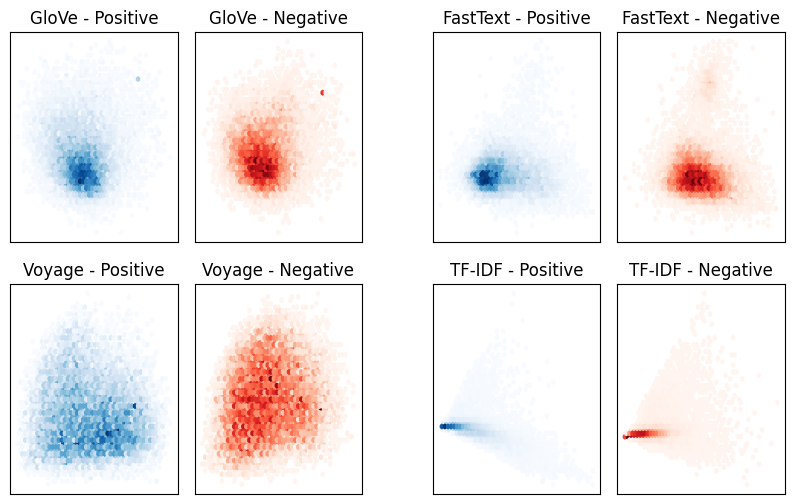

In [ ]:
fig = plt.figure(figsize=(10, 6))

outer_grid = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

for i, (embed, df) in enumerate(df_dict.items()):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i], wspace=0.1, hspace=0.1)

    df_0 = df[df['Label'] == 0]
    df_1 = df[df['Label'] == 1]

    for j in range(2):
        ax = plt.Subplot(fig, inner_grid[j])
        fig.add_subplot(ax)

        if j == 0:
            ax.hexbin(df_0['X1'], df_0['X2'], gridsize=50, cmap='Blues', mincnt=1)
            ax.set_title(f'{embed} - Positive')
        else:
            ax.hexbin(df_1['X1'], df_1['X2'], gridsize=50, cmap='Reds', mincnt=1)
            ax.set_title(f'{embed} - Negative')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)

#plt.savefig('images/embeddings_pca.png')
plt.show()


## Although it is subtle, we still notice trends in orientation depending on the label, especially for `voyage` and `fasttext`

# 2. Modeling
### For the metrics, we will use everything that is specific to classification (`accuracy`, `precision`, `recall`, `f1`, `confusion matrix`). Accuracy is relevant due to the balance of our data

### We must first prepare the test and validation sets

In [ ]:
print('Fitting TF-IDF...')
docs_tf_idf_test = tfidf.fit_transform(df_test['Content']).toarray()
docs_tf_idf_val = tfidf.fit_transform(df_val['Content']).toarray()
print('Done!')
print('Embedding with GloVe...')
docs_glove_test = df_test['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
docs_glove_val = df_val['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
print('Done!')
print('Embedding with FastText...')
docs_ft_test = df_test['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
docs_ft_val = df_val['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
print('Done!')
print('Embedding with Voyage...')
docs_batched_test = [df_test['Content'][i:i + 50].tolist() for i in range(0, len(df_test['Content']), 50)]
docs_voyage_test = []
for batch in tqdm(docs_batched_test):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage_test.extend(batch_embeddings)
docs_batched_val = [df_val['Content'][i:i + 50].tolist() for i in range(0, len(df_val['Content']), 50)]
docs_voyage_val = []
for batch in tqdm(docs_batched_val):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage_val.extend(batch_embeddings)
print('Done!')

Fitting TF-IDF...
Done!
Embedding with GloVe...


100%|██████████| 9984/9984 [00:00<00:00, 14093.78it/s]


Done!
Embedding with FastText...


100%|██████████| 9984/9984 [00:01<00:00, 9534.70it/s]


Done!
Embedding with Voyage...


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]

Done!


In [ ]:
print('Test Set Embeddings Shape', end='\n\n')
print('Length of TF-IDF vectors:', len(docs_tf_idf_test[0]))
print('Length of GloVe vectors:', len(docs_glove_test[0]))
print('Length of FastText vectors:', len(docs_ft_test[0]))
print('Length of Voyage vectors:', len(docs_voyage_test[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf_test))
print('Number of GloVe vectors:', len(docs_glove_test))
print('Number of FastText vectors:', len(docs_ft_test))
print('Number of Voyage vectors:', len(docs_voyage_test))
print('\n\n')
print('Validation Set Embeddings Shape', end='\n\n')
print('Length of TF-IDF vectors:', len(docs_tf_idf_val[0]))
print('Length of GloVe vectors:', len(docs_glove_val[0]))
print('Length of FastText vectors:', len(docs_ft_val[0]))
print('Length of Voyage vectors:', len(docs_voyage_val[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf_val))
print('Number of GloVe vectors:', len(docs_glove_val))
print('Number of FastText vectors:', len(docs_ft_val))
print('Number of Voyage vectors:', len(docs_voyage_val))

Test Set Embeddings Shape

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 9987
Number of GloVe vectors: 9987
Number of FastText vectors: 9987
Number of Voyage vectors: 9987



Validation Set Embeddings Shape

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 9984
Number of GloVe vectors: 9984
Number of FastText vectors: 9984
Number of Voyage vectors: 9984


In [ ]:
df_with_vectors_test = df_test.copy()
#df_with_vectors_test['TF-IDF'] = docs_tf_idf_test.tolist()
df_with_vectors_test['GloVe'] = docs_glove_test
df_with_vectors_test['FastText'] = docs_ft_test
df_with_vectors_test['Voyage'] = docs_voyage_test
download_csv(df_with_vectors_test, 'data_test_with_vectors.csv')

df_with_vectors_val = df_val.copy()
#df_with_vectors_val['TF-IDF'] = docs_tf_idf_val.tolist()
df_with_vectors_val['GloVe'] = docs_glove_val
df_with_vectors_val['FastText'] = docs_ft_val
df_with_vectors_val['Voyage'] = docs_voyage_val
download_csv(df_with_vectors_val, 'data_val_with_vectors.csv')

In [ ]:
df_with_vectors_test = load_csv('data_test_with_vectors.csv')
df_with_vectors_val = load_csv('data_val_with_vectors.csv')

In [ ]:
df_with_vectors.head()

,Content,Label,GloVe,FastText,Voyage
0,merg discuss slut merg discuss page ever held ...,0,"[0.396307966417887, 0.3437552653591741, 0.1330...","[0.013699262402951717, 0.00045087654143571854,...","[0.020471060648560524, 0.003549023065716028, -..."
1,dunno look okay like,0,"[0.23359980136156083, 0.12730599641799928, 0.1...","[-0.028239358216524124, 0.06274276971817017, 0...","[0.014980827458202839, 0.0034704094287008047, ..."
2,ipak odustajem haha hahaha,0,"[0.8878275007009506, 0.22010250389575958, 0.32...","[-0.009178552776575089, 0.0492682047188282, 0....","[0.013682648539543152, 0.019817529246211052, -..."
3,moslem terrorist rather vigilant killer whale,1,"[-0.35405429133347105, 0.21748528948851995, -0...","[-0.045700207352638245, 0.0079624829813838, -0...","[0.022014306858181953, 0.004979489371180534, -..."
4,meant claim fuck boi bwhahhahahaha,1,"[0.33812599182128905, 0.3702240020036697, -0.0...","[-0.0728086456656456, -0.007704657502472401, 0...","[0.023333314806222916, 0.00996093638241291, -0..."


In [ ]:
df_with_vectors_test.head()

,Content,Label,GloVe,FastText,Voyage
0,life differ one anoth son,1,"[0.05341993241260449, 0.020065002143383026, -0...","[-0.015524527989327908, -0.016127189621329308,...","[0.024511517956852913, 0.010551409795880318, -..."
1,ooh worth capricorncapricorn crystal silver ba...,1,"[-0.24783592258030787, -0.24551213227021387, 0...","[-0.056029368191957474, 0.04141700267791748, 0...","[0.044766977429389954, -0.016489360481500626, ..."
2,real lupus erythematosus hope peopl hither rea...,1,"[-0.06895894748676154, 0.013367330034573873, -...","[-0.01760084368288517, 0.01128313597291708, 0....","[-0.0010086046531796455, 0.01235181838274002, ..."
3,page use hi hi know discuss close still show p...,0,"[0.5058850753121078, 0.22819341346621513, 0.03...","[0.027371583506464958, 0.1063939556479454, 0.0...","[0.006542394403368235, 0.00820163358002901, -0..."
4,ford knew moment came forward anonym name woul...,1,"[0.0809733620421453, 0.18893477526690924, 0.13...","[-0.00885710772126913, 0.01862104795873165, 0....","[0.005794798023998737, 0.013458643108606339, -..."


In [ ]:
df_with_vectors_val.head()

,Content,Label,GloVe,FastText,Voyage
0,hour midnight said call girl awkward,0,"[0.03305572058473315, 0.4437462772641863, 0.18...","[-0.031698163598775864, 0.0775686651468277, 0....","[-0.004964085761457682, 0.009776967577636242, ..."
1,defund action send inaugur,1,"[0.15838724840432405, 0.56615000218153, -0.049...","[-0.010622715577483177, -0.03983072191476822, ...","[0.015210222452878952, 0.012634547427296638, -..."
2,also scientif evid err safe side whatev need m...,1,"[0.026012308035905544, 0.1344436131990873, -0....","[0.007599100936204195, 0.02113112062215805, 0....","[0.00793453585356474, 0.0017771729035302997, -..."
3,serious say think truth starter one ignor pric...,1,"[0.24492387050906053, 0.22207846194326591, -0....","[-0.018434209749102592, 0.017132332548499107, ...","[0.01141525711864233, -0.027929048985242844, -..."
4,often ad coverag major miss viewpoint prefer t...,0,"[0.26919693098618436, 0.30409315185478103, 0.1...","[0.004747851751744747, 0.010076402686536312, 0...","[-0.010252219624817371, -0.004589424934238195,..."


## First, we will build our initial models using the embeddings we have.

### First, we will try the naive Bayes models.

In [ ]:
# Multinomial Naive Bayes & Bernoulli Naive Bayes are used for TF-IDF vectors
mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()

In [ ]:
model_scores = {
    'Multinomial Naive Bayes': {embed: {} for embed in embed_list},
    'Gaussian Naive Bayes': {embed: {} for embed in embed_list},
    'Bernoulli Naive Bayes': {embed: {} for embed in embed_list},
}

In [ ]:
tfidf = TfidfVectorizer(max_features=10000)
docs_tf_idf = tfidf.fit_transform(df_with_vectors['Content']).toarray()
docs_tf_idf_test = tfidf.transform(df_with_vectors_test['Content']).toarray()

In [ ]:
for embed in tqdm(embed_list):
    y_train = df_with_vectors['Label'].tolist()
    y_test = df_with_vectors_test['Label'].tolist()
    if embed == 'TF-IDF':
        X_train = docs_tf_idf
        mnb.fit(X_train, y_train)
        bnb.fit(X_train, y_train)
        X_test = docs_tf_idf_test
        start = perf_counter()
        preds = mnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Multinomial Naive Bayes']['TF-IDF']['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['f1'] = f1_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['precision'] = precision_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['recall'] = recall_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['time'] = end

        start = perf_counter()
        preds = bnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['f1'] = f1_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['precision'] = precision_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['recall'] = recall_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['time'] = end
    else:
        X_train = df_with_vectors[embed].tolist()
        gnb.fit(X_train, y_train)
        X_test = df_with_vectors_test[embed].tolist()
        start = perf_counter()
        preds = gnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Gaussian Naive Bayes'][embed]['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['f1'] = f1_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['precision'] = precision_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['recall'] = recall_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['time'] = end

100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


In [69]:
def plot_scores(model_scores, output_file):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.flatten()

    metrics = ['accuracy', 'f1', 'precision', 'recall']
    model_embeddings = []
    scores = {metric: [] for metric in metrics}
    times = []

    for model in model_scores:
        for embed in model_scores[model]:
            if not model_scores[model][embed]:
                continue

            model_embeddings.append(f"{model}\n{embed}")
            for metric in metrics:
                scores[metric].append(model_scores[model][embed].get(metric, None))
            times.append(model_scores[model][embed].get('time', None))

    clean_indices = [i for i, t in enumerate(times) if t is not None]
    model_embeddings = [model_embeddings[i] for i in clean_indices]
    times = [times[i] for i in clean_indices]
    for metric in metrics:
        scores[metric] = [scores[metric][i] for i in clean_indices]

    times = np.array(times)
    sizes = (times - times.min()) / (times.max() - times.min()) * 100 + 10

    for ax, metric in zip(axs, metrics):
        sc = ax.scatter(model_embeddings, scores[metric], c=times, cmap='coolwarm', s=sizes)
        ax.set_title(metric.capitalize())
        ax.set_xlabel('Model + Embedding')
        ax.set_ylabel('Score')
        ax.set_xticklabels(model_embeddings, rotation=45)
        ax.grid(True, axis='y')

    cbar = fig.colorbar(sc, ax=axs, cax=fig.add_axes([0.98, 0.2, 0.02, 0.4]), aspect=8)
    cbar.ax.set_title('  Time(s)')

    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()


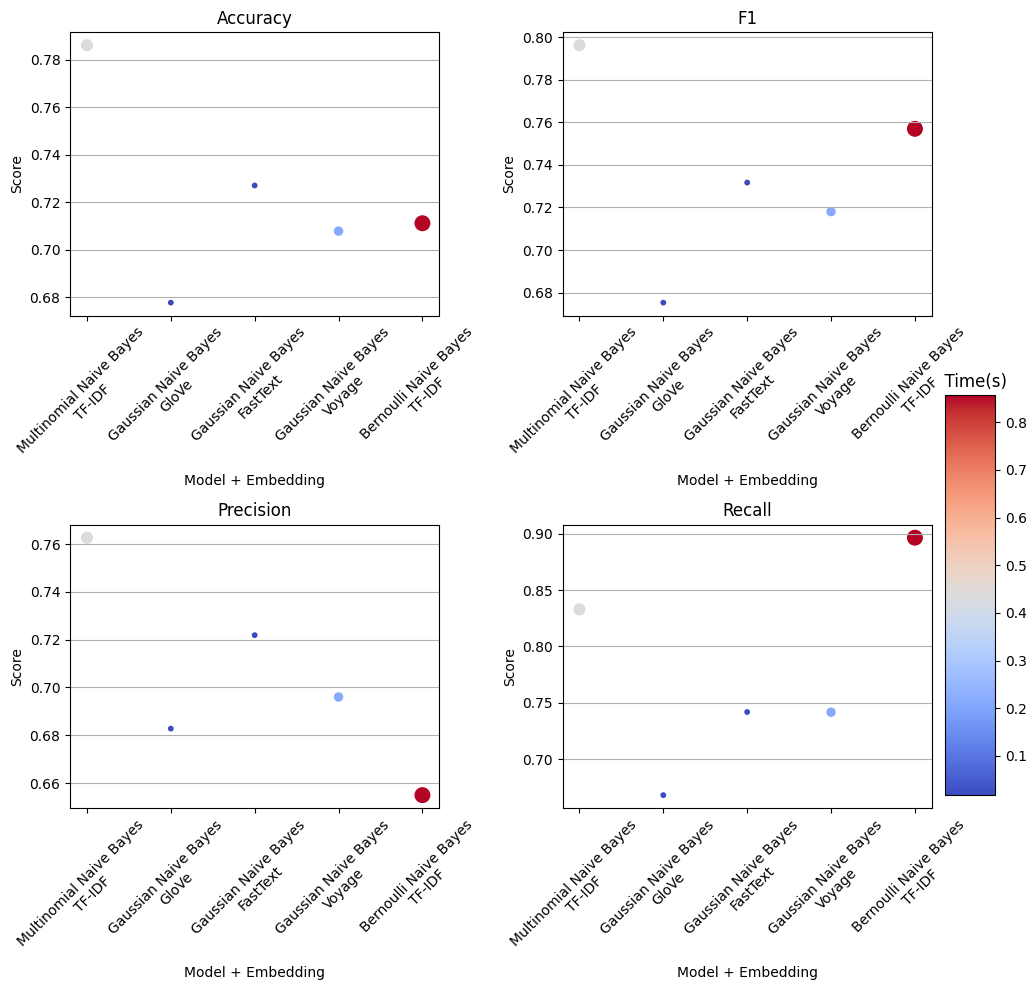

In [ ]:
plot_scores(model_scores, 'images/naive_bayes_scores.png')

### We notice that among the four metrics, the model performing the best is `TF-IDF+MultinomialNB`. It has the best results but not the best inference time. We can note the slowness of inference with the Voyage embeddings, in addition to the fact that their performance does not surpass that of GloVe by much. **Let's recall the embeddings sizes (50 for GloVe and 1024 for Voyage-02)**

In [ ]:
with open('model_scores.json', 'w') as f:
    json.dump(model_scores, f)

## Now we are going to try some classic machine learning algorithms: `SVM` `LogisticRegression` `RandomForest` `XGBoost`

### We will need to optimize the hyperparameters, and to do this we will use `Optuna`

In [ ]:
# SGDCLassifier with hinge loss (SVM).

embed_list = ['GloVe', 'FastText', 'Voyage','TF-IDF']

df_with_vectors_with_val = pd.concat([df_with_vectors, df_with_vectors_val], ignore_index=True)

def svm_objective(trial, docs_train):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
        'loss': 'hinge',
        'random_state': 42
    }
    model = SGDClassifier(**params)
    scores = cross_val_score(model, docs_train, df_with_vectors_with_val['Label'], cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()


[I 2024-01-28 12:55:35,210] A new study created in memory with name: SGDClassifier SVM


In [ ]:
sgd_best_params = {embed: {} for embed in embed_list}
study_list = []

for embed in embed_list:
    if embed == 'TF-IDF':
        continue
    else:
        print(f'----- {embed} -----', end='\n\n')
        study = optuna.create_study(direction='maximize')

        study.optimize(lambda trial: svm_objective(trial, df_with_vectors_with_val[embed].tolist()), n_trials=50, show_progress_bar=True)

        sgd_best_params[embed] = study.best_params

        study_list.append(study)

In [ ]:
print('SGDClassifier SVM Best Parameters' , end='\n\n')
for embed in embed_list:
    print(f'{embed}: {sgd_best_params[embed]}')

SGDClassifier SVM Best Parameters

GloVe: {'alpha': 0.0013181627679587874, 'penalty': 'elasticnet', 'max_iter': 4575, 'tol': 0.0034269237212155804}
FastText: {'alpha': 1.1521784073010557e-05, 'penalty': 'l1', 'max_iter': 3865, 'tol': 0.0008140477658672723}
Voyage: {'alpha': 2.0558036932258994e-05, 'penalty': 'l2', 'max_iter': 4733, 'tol': 0.0004227471854846425}
TF-IDF: {}


In [ ]:
for study,embed in zip(study_list, embed_list):
    try:
        study.trials_dataframe().to_csv(f'stud/svm_trials_{embed}.csv', mode='a', index=False)
    except:
        break

In [ ]:
df_svm_trials_glove = pd.read_csv('stud/svm_trials_GloVe.csv')
df_svm_trials_fasttext = pd.read_csv('stud/svm_trials_FastText.csv')
df_svm_trials_voyage = pd.read_csv('stud/svm_trials_Voyage.csv')

In [ ]:
df_svm_trials_glove.head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_max_iter,params_penalty,params_tol,state
0,0,0.695794,2024-01-28 12:56:30.357760,2024-01-28 12:56:37.012848,0 days 00:00:06.655088,0.068645,4540,elasticnet,0.000491,COMPLETE
1,1,0.708062,2024-01-28 12:56:37.020700,2024-01-28 12:56:41.763068,0 days 00:00:04.742368,0.004907,1717,l1,0.048644,COMPLETE
2,2,0.680320,2024-01-28 12:56:41.768269,2024-01-28 12:56:47.648709,0 days 00:00:05.880440,0.000024,1564,l1,0.000083,COMPLETE
3,3,0.712569,2024-01-28 12:56:47.654526,2024-01-28 12:56:52.883802,0 days 00:00:05.229276,0.000078,4429,l1,0.000765,COMPLETE
4,4,0.713545,2024-01-28 12:56:52.888487,2024-01-28 12:56:57.563659,0 days 00:00:04.675172,0.000935,2295,l2,0.000023,COMPLETE


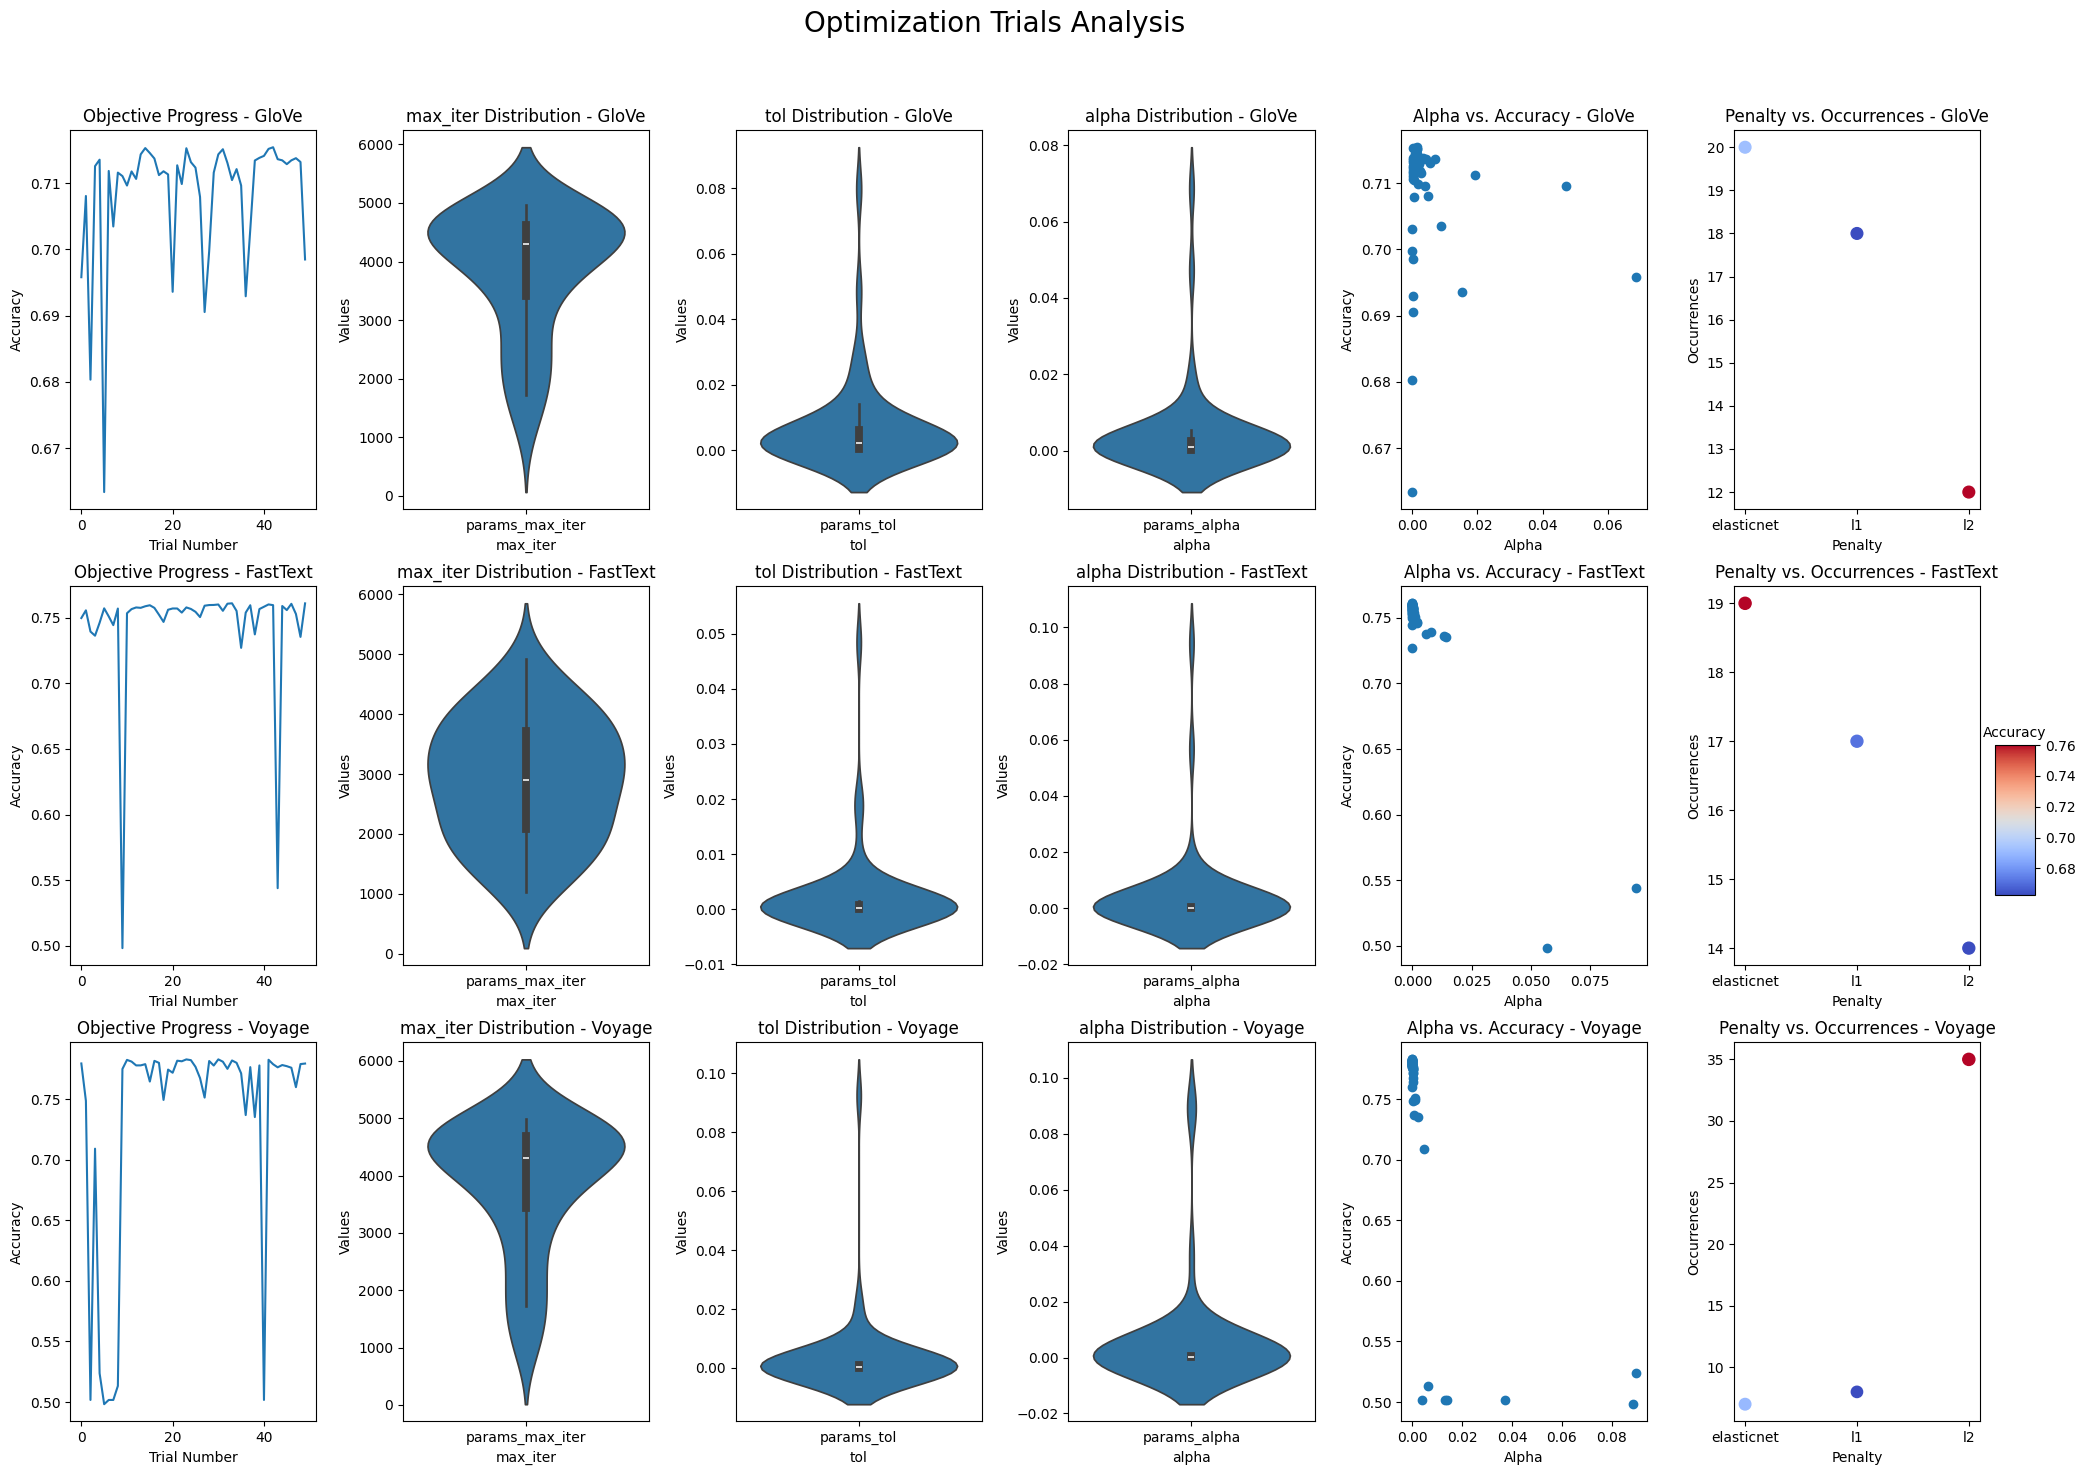

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(20, 15))
fig.suptitle('Optimization Trials Analysis', fontsize=20)

for i, (df, embed) in enumerate(zip([df_svm_trials_glove, df_svm_trials_fasttext, df_svm_trials_voyage], embed_list[:-1])):
    axes[i, 0].plot(df['number'], df['value'])
    axes[i, 0].set_title(f'Objective Progress - {embed}')
    axes[i, 0].set_xlabel('Trial Number')
    axes[i, 0].set_ylabel('Accuracy')

    sns.violinplot(data=df[['params_max_iter']], ax=axes[i, 1])
    axes[i, 1].set_title(f'max_iter Distribution - {embed}')
    axes[i, 1].set_xlabel('max_iter')
    axes[i, 1].set_ylabel('Values')

    sns.violinplot(data=df[['params_tol']], ax=axes[i, 2])
    axes[i, 2].set_title(f'tol Distribution - {embed}')
    axes[i, 2].set_xlabel('tol')
    axes[i, 2].set_ylabel('Values')

    sns.violinplot(data=df[['params_alpha']], ax=axes[i, 3])
    axes[i, 3].set_title(f'alpha Distribution - {embed}')
    axes[i, 3].set_xlabel('alpha')
    axes[i, 3].set_ylabel('Values')

    axes[i, 4].scatter(df['params_alpha'], df['value'])
    axes[i, 4].set_title(f'Alpha vs. Accuracy - {embed}')
    axes[i, 4].set_xlabel('Alpha')
    axes[i, 4].set_ylabel('Accuracy')

    df_grouped = df.groupby('params_penalty').agg({'number': 'count', 'value': 'mean'}).reset_index()

    scatter = axes[i, 5].scatter(df_grouped['params_penalty'], df_grouped['number'], s=df_grouped['value']*100, c=df_grouped['value'], cmap='coolwarm')
    axes[i, 5].set_title(f'Penalty vs. Occurrences - {embed}')
    axes[i, 5].set_xlabel('Penalty')
    axes[i, 5].set_ylabel('Occurrences')

cbar = fig.colorbar(scatter, ax=axs, cax=fig.add_axes([1, 0.39, 0.02, 0.1]))
cbar.orientation = 'horizontal'
cbar.ax.set_title('Accuracy', fontdict={'fontsize': 10})
plt.tight_layout()
plt.subplots_adjust(top=0.9)
#plt.savefig('images/svm_trials.png')
plt.show()

### The figure above summarizes the hyperparameter search done with Optuna. For each embedding model, it shows the accuracy in relation to the trials, the distribution of the parameters max_iter, tol, and alpha, as well as alpha in relation to accuracy, and the number of occurrences of each penalty with the average score visualized by color. We can notice that for FastText, the distribution of max_iter is less concentrated than for the other two. We can also see that they all converge towards a fairly low alpha value. Finally, we observe that they do not tend towards the same penalties. Glove and FastText have favored elasticnet more, while Voyage has significantly more often opted for the l2 penalty. However, Glove and Voyage achieved better results with the l2 penalty, whereas the best for FastText seems to be elasticnet

### Now let's look at the metrics on the test set and save them in our dictionary

In [ ]:
svm_models = [(embed, SGDClassifier(**sgd_best_params[embed], random_state=42)) for embed in embed_list[:-1]]
svm_models

[('GloVe',
  SGDClassifier(alpha=0.0013181627679587874, max_iter=4575, penalty='elasticnet',
                random_state=42, tol=0.0034269237212155804)),
 ('FastText',
  SGDClassifier(alpha=1.1521784073010557e-05, max_iter=3865, penalty='l1',
                random_state=42, tol=0.0008140477658672723)),
 ('Voyage',
  SGDClassifier(alpha=2.0558036932258994e-05, max_iter=4733, random_state=42,
                tol=0.0004227471854846425))]

In [ ]:
with open('model_scores.json', 'r') as f:
    model_scores = json.load(f)
print(model_scores)

{'Multinomial Naive Bayes': {'GloVe': {}, 'FastText': {}, 'Voyage': {}, 'TF-IDF': {'accuracy': 0.7861219585461099, 'f1': 0.7962609690957649, 'precision': 0.7626530239356842, 'recall': 0.8329674715625623, 'time': 0.44068196100124624}}, 'Gaussian Naive Bayes': {'GloVe': {'accuracy': 0.6776809852808652, 'f1': 0.675274891556542, 'precision': 0.6827825377396981, 'recall': 0.6679305527838755, 'time': 0.017853402998298407}, 'FastText': {'accuracy': 0.7270451587063183, 'f1': 0.7316929133858268, 'precision': 0.7218877451932414, 'recall': 0.7417681101576532, 'time': 0.018098430999089032}, 'Voyage': {'accuracy': 0.7078201662160809, 'f1': 0.7180676328502416, 'precision': 0.6960104888555909, 'recall': 0.7415685491917781, 'time': 0.21266904499861994}, 'TF-IDF': {}}, 'Bernoulli Naive Bayes': {'GloVe': {}, 'FastText': {}, 'Voyage': {}, 'TF-IDF': {'accuracy': 0.7111244618003404, 'f1': 0.7569707691011709, 'precision': 0.6549562682215744, 'recall': 0.8966274196767112, 'time': 0.8572206280005048}}}


In [ ]:
model_scores['SGDClassifier SVM'] = {embed: {} for embed in embed_list[:-1]}

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


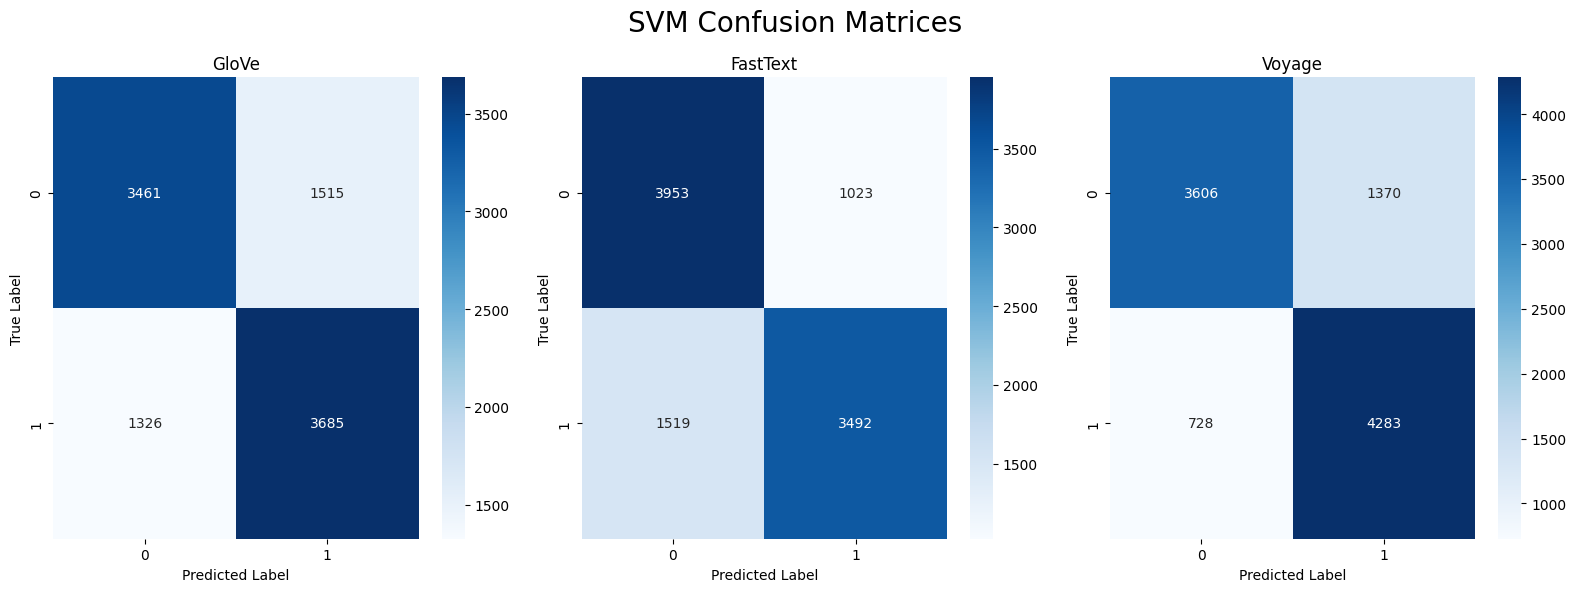

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs = axs.flatten()
fig.suptitle('SVM Confusion Matrices', fontsize=20)

for model,svm in tqdm(svm_models):
    svm.fit(df_with_vectors[model].tolist(), df_with_vectors['Label'])
    start = perf_counter()
    preds = svm.predict(df_with_vectors_test[model].tolist())
    end = perf_counter() - start
    model_scores['SGDClassifier SVM'][model] = {
        'accuracy': accuracy_score(df_with_vectors_test['Label'], preds),
        'f1': f1_score(df_with_vectors_test['Label'], preds),
        'precision': precision_score(df_with_vectors_test['Label'], preds),
        'recall': recall_score(df_with_vectors_test['Label'], preds),
        'time': end
    }

    cm = confusion_matrix(df_with_vectors_test['Label'], preds)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[svm_models.index((model, svm))], cmap='Blues')
    axs[svm_models.index((model, svm))].set_title(model)
    axs[svm_models.index((model, svm))].set_xlabel('Predicted Label')
    axs[svm_models.index((model, svm))].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('images/svm_confusion_matrices.png')
plt.show()

In [ ]:
print(model_scores)

{'Multinomial Naive Bayes': {'GloVe': {}, 'FastText': {}, 'Voyage': {}, 'TF-IDF': {'accuracy': 0.7861219585461099, 'f1': 0.7962609690957649, 'precision': 0.7626530239356842, 'recall': 0.8329674715625623, 'time': 0.44068196100124624}}, 'Gaussian Naive Bayes': {'GloVe': {'accuracy': 0.6776809852808652, 'f1': 0.675274891556542, 'precision': 0.6827825377396981, 'recall': 0.6679305527838755, 'time': 0.017853402998298407}, 'FastText': {'accuracy': 0.7270451587063183, 'f1': 0.7316929133858268, 'precision': 0.7218877451932414, 'recall': 0.7417681101576532, 'time': 0.018098430999089032}, 'Voyage': {'accuracy': 0.7078201662160809, 'f1': 0.7180676328502416, 'precision': 0.6960104888555909, 'recall': 0.7415685491917781, 'time': 0.21266904499861994}, 'TF-IDF': {}}, 'Bernoulli Naive Bayes': {'GloVe': {}, 'FastText': {}, 'Voyage': {}, 'TF-IDF': {'accuracy': 0.7111244618003404, 'f1': 0.7569707691011709, 'precision': 0.6549562682215744, 'recall': 0.8966274196767112, 'time': 0.8572206280005048}}, 'SGDCl

### The figure above shows us the three confusion matrices for the use of the SVM. We notice that the best embedding model here is `Voyage-02`. We can also note that it has twice as many errors on the positive corpora as on the negative ones

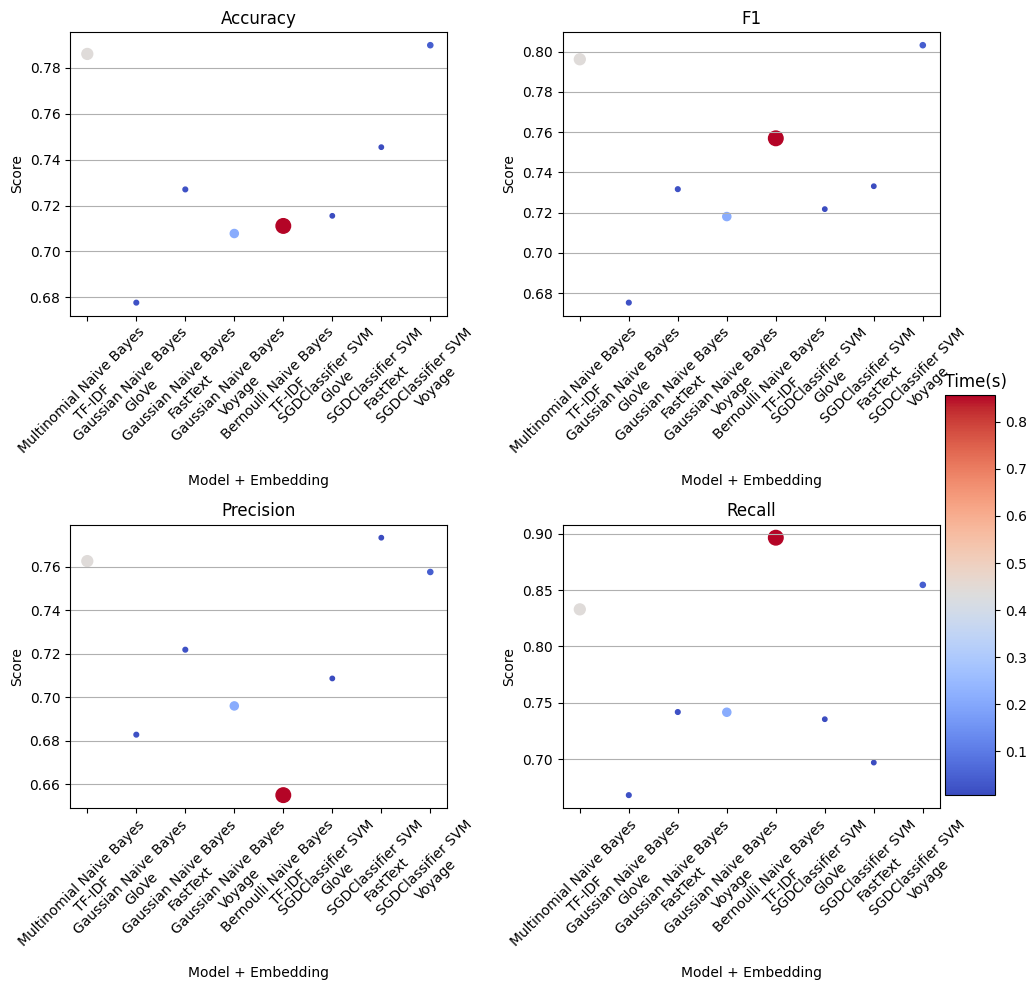

In [ ]:
plot_scores(model_scores, 'images/svm_scores.png')

In [ ]:
with open('model_scores.json', 'w') as f:
    json.dump(model_scores, f)

### `SVM+Voyage-02` even surpasses `TF-IDF+MultinomialNB` with better accuracy and f1 scores. However, it is worth noting that `FastText+SVM` is the best in precision

### We will now continue by doing the same work with Logistic Regression

In [ ]:
df_with_vectors = load_csv('data_train_with_vectors.csv')
df_with_vectors_test = load_csv('data_test_with_vectors.csv')
df_with_vectors_val = load_csv('data_val_with_vectors.csv')

df_with_vectors_with_val = pd.concat([df_with_vectors, df_with_vectors_val], ignore_index=True)

In [ ]:
df_with_vectors_with_val.head()

,Content,Label,GloVe,FastText,Voyage
0,merg discuss slut merg discuss page ever held ...,0,"[0.396307966417887, 0.3437552653591741, 0.1330...","[0.013699262402951717, 0.00045087654143571854,...","[0.020471060648560524, 0.003549023065716028, -..."
1,dunno look okay like,0,"[0.23359980136156083, 0.12730599641799928, 0.1...","[-0.028239358216524124, 0.06274276971817017, 0...","[0.014980827458202839, 0.0034704094287008047, ..."
2,ipak odustajem haha hahaha,0,"[0.8878275007009506, 0.22010250389575958, 0.32...","[-0.009178552776575089, 0.0492682047188282, 0....","[0.013682648539543152, 0.019817529246211052, -..."
3,moslem terrorist rather vigilant killer whale,1,"[-0.35405429133347105, 0.21748528948851995, -0...","[-0.045700207352638245, 0.0079624829813838, -0...","[0.022014306858181953, 0.004979489371180534, -..."
4,meant claim fuck boi bwhahhahahaha,1,"[0.33812599182128905, 0.3702240020036697, -0.0...","[-0.0728086456656456, -0.007704657502472401, 0...","[0.023333314806222916, 0.00996093638241291, -0..."


In [ ]:
# SGDClassifier with log loss (Logistic Regression).
embed_list = ['GloVe', 'FastText', 'Voyage','TF-IDF']

def lr_objective(trial, docs_train):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
        'loss': 'log_loss',
        'random_state': 42
    }
    model = SGDClassifier(**params)
    scores = cross_val_score(model, docs_train, df_with_vectors_with_val['Label'], cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()


[I 2024-01-28 19:33:03,940] A new study created in memory with name: SGDClassifier LR


In [ ]:
sgdlr_best_params = {embed: {} for embed in embed_list}
study_list = []

for embed in embed_list:
    if embed == 'TF-IDF':
        continue
    else:
        print(f'----- {embed} -----', end='\n\n')
        study = optuna.create_study(direction='maximize')

        study.optimize(lambda trial: lr_objective(trial, df_with_vectors_with_val[embed].tolist()), n_trials=50, show_progress_bar=True)

        sgdlr_best_params[embed] = study.best_params

        study_list.append(study)

In [ ]:
print('SGDClassifier Logistic Regression Best Parameters' , end='\n\n')
for embed in embed_list:
    print(f'{embed}: {sgdlr_best_params[embed]}')

SGDClassifier Logistic Regression Best Parameters

GloVe: {'alpha': 0.0018491638154561076, 'penalty': 'l2', 'max_iter': 4614, 'tol': 0.0017207523410265558}
FastText: {'alpha': 6.063084353293512e-05, 'penalty': 'elasticnet', 'max_iter': 4430, 'tol': 0.0011128771187788066}
Voyage: {'alpha': 1.4161543603281284e-05, 'penalty': 'l1', 'max_iter': 1185, 'tol': 0.0020957371096952653}
TF-IDF: {}


In [ ]:
for study,embed in zip(study_list, embed_list):
    try:
        study.trials_dataframe().to_csv(f'stud/lr_trials_{embed}.csv', mode='a', index=False)
    except:
        break

In [ ]:
df_lr_trials_glove = pd.read_csv('stud/lr_trials_GloVe.csv')
df_lr_trials_fasttext = pd.read_csv('stud/lr_trials_FastText.csv')
df_lr_trials_voyage = pd.read_csv('stud/lr_trials_Voyage.csv')


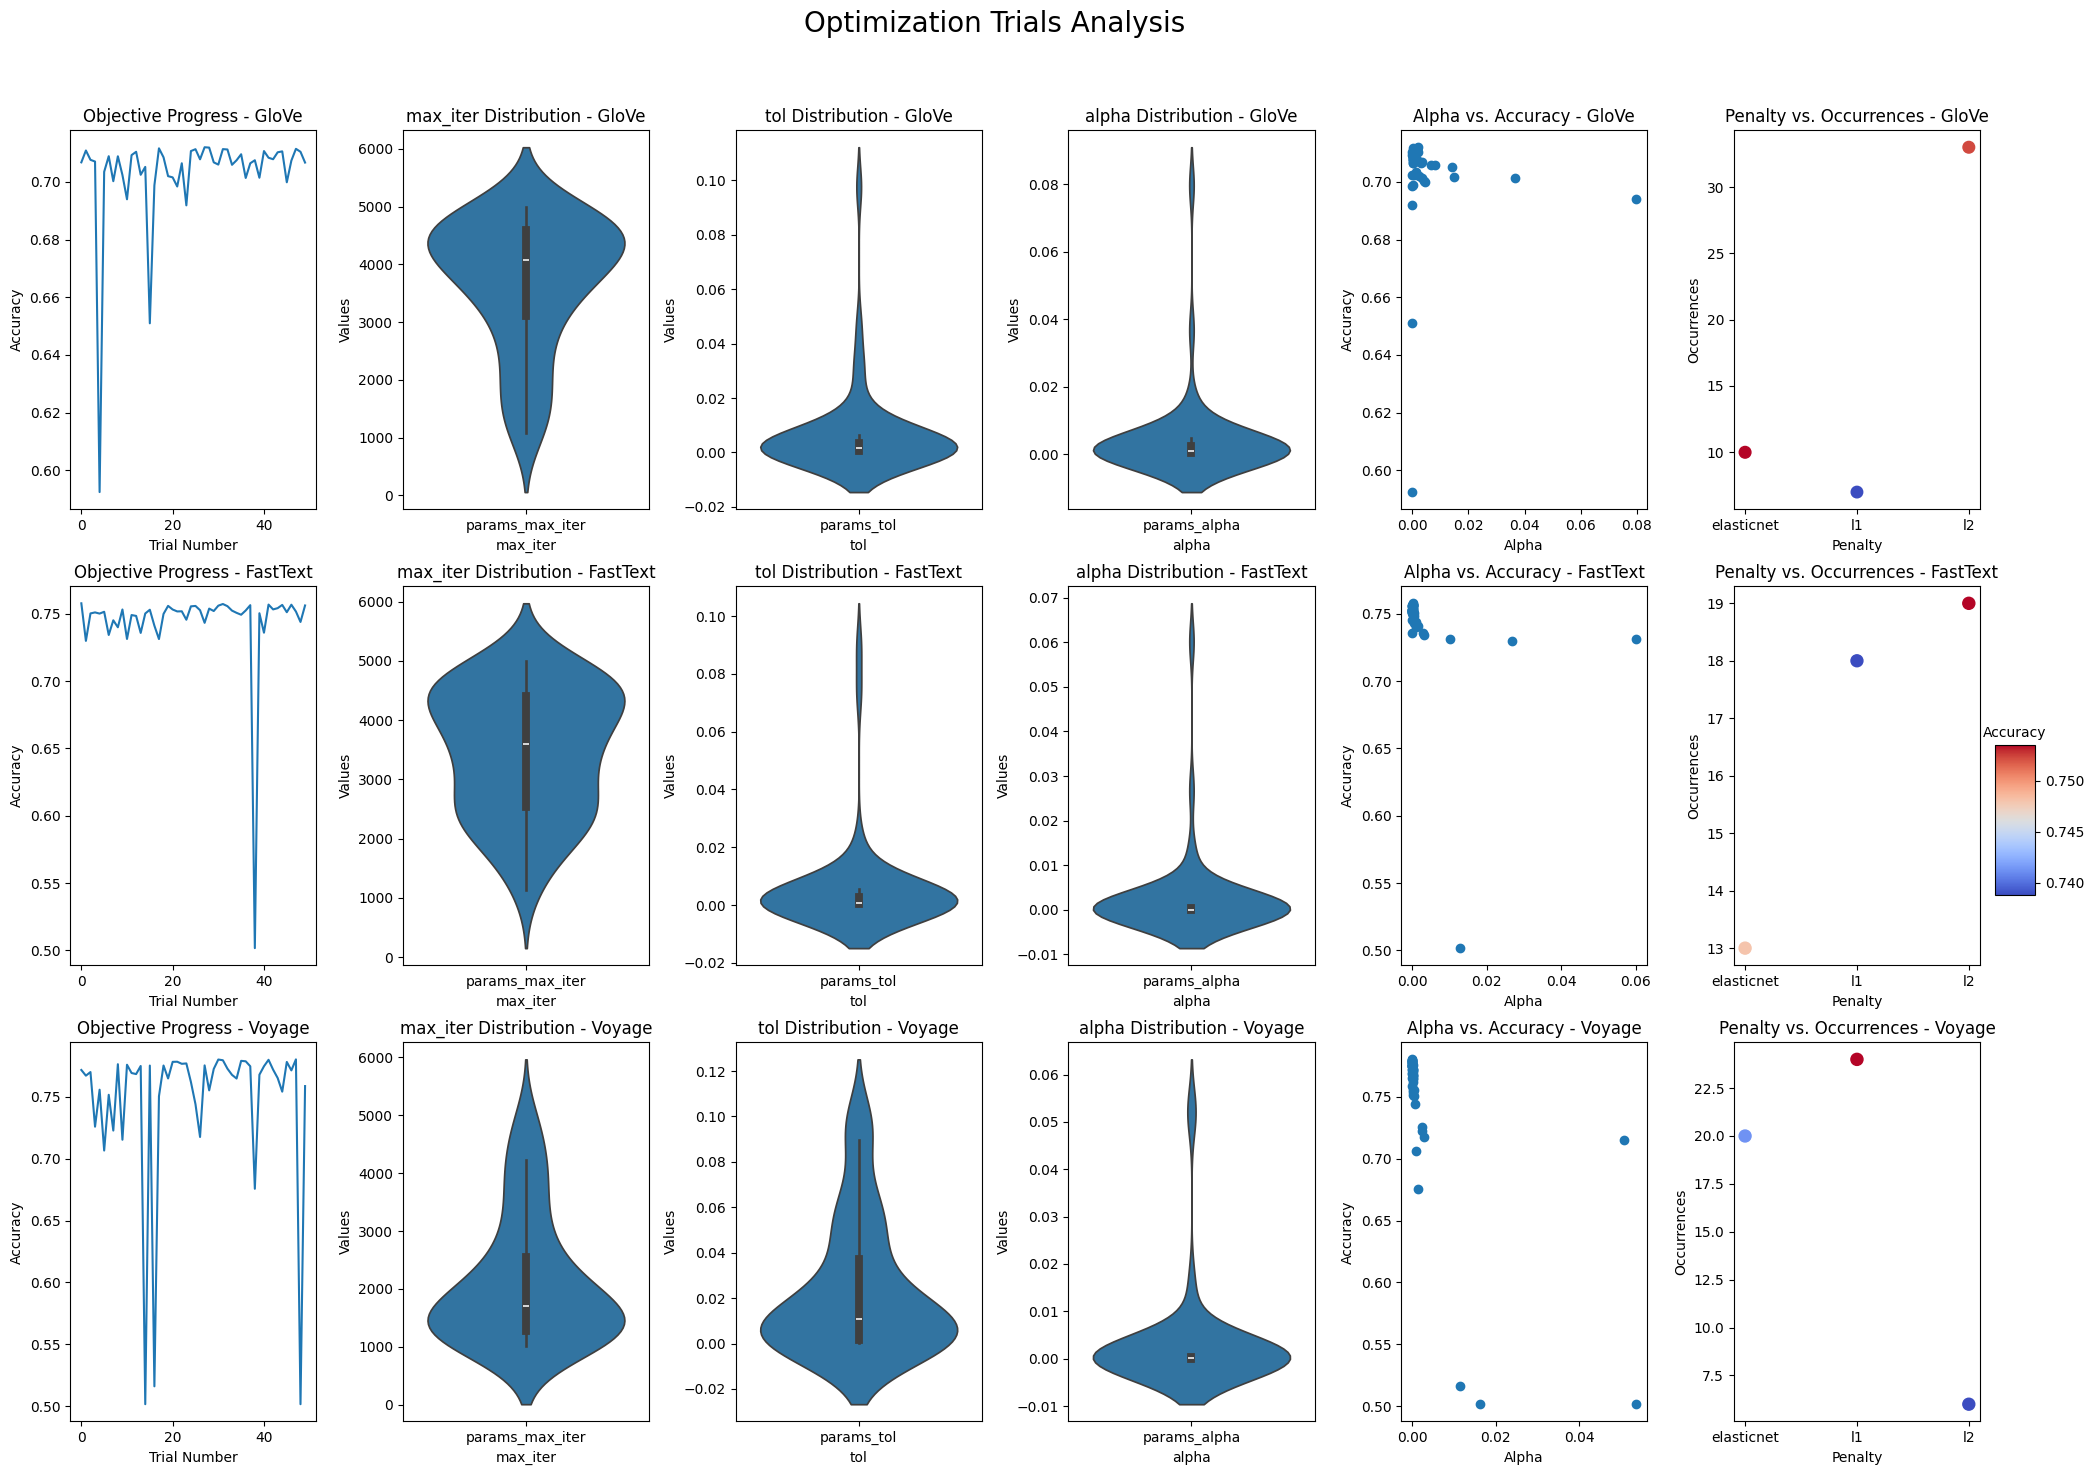

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(20, 15))
fig.suptitle('Optimization Trials Analysis', fontsize=20)

for i, (df, embed) in enumerate(zip([df_lr_trials_glove, df_lr_trials_fasttext, df_lr_trials_voyage], embed_list[:-1])):
    axes[i, 0].plot(df['number'], df['value'])
    axes[i, 0].set_title(f'Objective Progress - {embed}')
    axes[i, 0].set_xlabel('Trial Number')
    axes[i, 0].set_ylabel('Accuracy')

    sns.violinplot(data=df[['params_max_iter']], ax=axes[i, 1])
    axes[i, 1].set_title(f'max_iter Distribution - {embed}')
    axes[i, 1].set_xlabel('max_iter')
    axes[i, 1].set_ylabel('Values')

    sns.violinplot(data=df[['params_tol']], ax=axes[i, 2])
    axes[i, 2].set_title(f'tol Distribution - {embed}')
    axes[i, 2].set_xlabel('tol')
    axes[i, 2].set_ylabel('Values')

    sns.violinplot(data=df[['params_alpha']], ax=axes[i, 3])
    axes[i, 3].set_title(f'alpha Distribution - {embed}')
    axes[i, 3].set_xlabel('alpha')
    axes[i, 3].set_ylabel('Values')

    axes[i, 4].scatter(df['params_alpha'], df['value'])
    axes[i, 4].set_title(f'Alpha vs. Accuracy - {embed}')
    axes[i, 4].set_xlabel('Alpha')
    axes[i, 4].set_ylabel('Accuracy')

    df_grouped = df.groupby('params_penalty').agg({'number': 'count', 'value': 'mean'}).reset_index()

    scatter = axes[i, 5].scatter(df_grouped['params_penalty'], df_grouped['number'], s=df_grouped['value']*100, c=df_grouped['value'], cmap='coolwarm')
    axes[i, 5].set_title(f'Penalty vs. Occurrences - {embed}')
    axes[i, 5].set_xlabel('Penalty')
    axes[i, 5].set_ylabel('Occurrences')

cbar = fig.colorbar(scatter, ax=axs, cax=fig.add_axes([1, 0.39, 0.02, 0.1]))
cbar.orientation = 'horizontal'
cbar.ax.set_title('Accuracy', fontdict={'fontsize': 10})
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('images/lr_trials.png')
plt.show()

### We find exactly the same graph as with the `SVM`. We converge towards the same alpha value for all three models. Here, we notice an effective l1 penalty for `Voyage-02`, but with a tol parameter that has a less concentrated distribution.

### Let's see how it performs on the test set

In [ ]:
with open('model_scores.json', 'r') as f:
    model_scores = json.load(f)

In [ ]:
print(model_scores)

{'Multinomial Naive Bayes': {'GloVe': {}, 'FastText': {}, 'Voyage': {}, 'TF-IDF': {'accuracy': 0.7861219585461099, 'f1': 0.7962609690957649, 'precision': 0.7626530239356842, 'recall': 0.8329674715625623, 'time': 0.44068196100124624}}, 'Gaussian Naive Bayes': {'GloVe': {'accuracy': 0.6776809852808652, 'f1': 0.675274891556542, 'precision': 0.6827825377396981, 'recall': 0.6679305527838755, 'time': 0.017853402998298407}, 'FastText': {'accuracy': 0.7270451587063183, 'f1': 0.7316929133858268, 'precision': 0.7218877451932414, 'recall': 0.7417681101576532, 'time': 0.018098430999089032}, 'Voyage': {'accuracy': 0.7078201662160809, 'f1': 0.7180676328502416, 'precision': 0.6960104888555909, 'recall': 0.7415685491917781, 'time': 0.21266904499861994}, 'TF-IDF': {}}, 'Bernoulli Naive Bayes': {'GloVe': {}, 'FastText': {}, 'Voyage': {}, 'TF-IDF': {'accuracy': 0.7111244618003404, 'f1': 0.7569707691011709, 'precision': 0.6549562682215744, 'recall': 0.8966274196767112, 'time': 0.8572206280005048}}, 'SGDCl

In [ ]:
model_scores['SGDClassifier Logistic Regression'] = {embed: {} for embed in embed_list[:-1]}

0it [00:00, ?it/s]

3it [00:08,  2.75s/it]


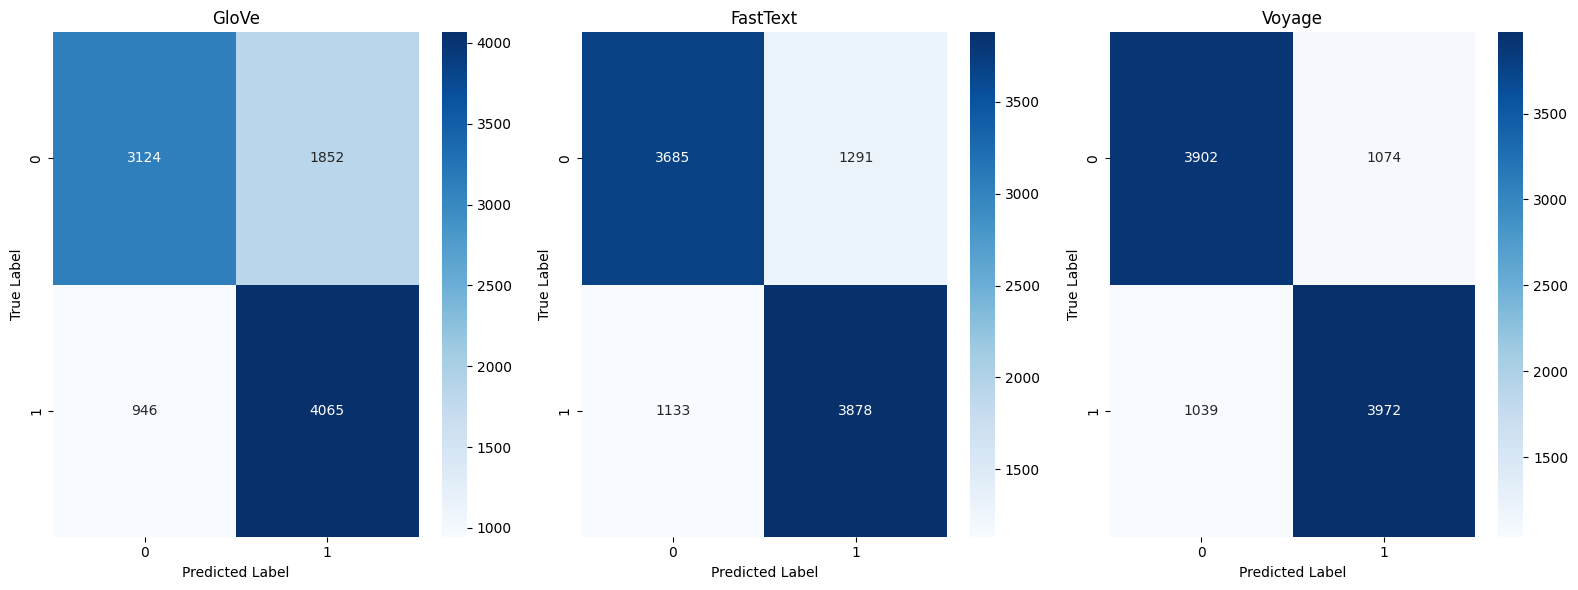

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs = axs.flatten()

for model,embed in tqdm(zip(embed_list[:-1], embed_list[:-1])):
    lr = SGDClassifier(**sgdlr_best_params[model], random_state=42)
    lr.fit(df_with_vectors[model].tolist(), df_with_vectors['Label'])
    start = perf_counter()
    preds = lr.predict(df_with_vectors_test[model].tolist())
    end = perf_counter() - start
    model_scores['SGDClassifier Logistic Regression'][model] = {
        'accuracy': accuracy_score(df_with_vectors_test['Label'], preds),
        'f1': f1_score(df_with_vectors_test['Label'], preds),
        'precision': precision_score(df_with_vectors_test['Label'], preds),
        'recall': recall_score(df_with_vectors_test['Label'], preds),
        'time': end
    }

    cm = confusion_matrix(df_with_vectors_test['Label'], preds)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[embed_list.index(embed)], cmap='Blues')
    axs[embed_list.index(embed)].set_title(embed)
    axs[embed_list.index(embed)].set_xlabel('Predicted Label')
    axs[embed_list.index(embed)].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('images/lr_confusion_matrices.png')
plt.show()

### `Voyage` also seems to be better with this model, however, `FastText` appears to be very close

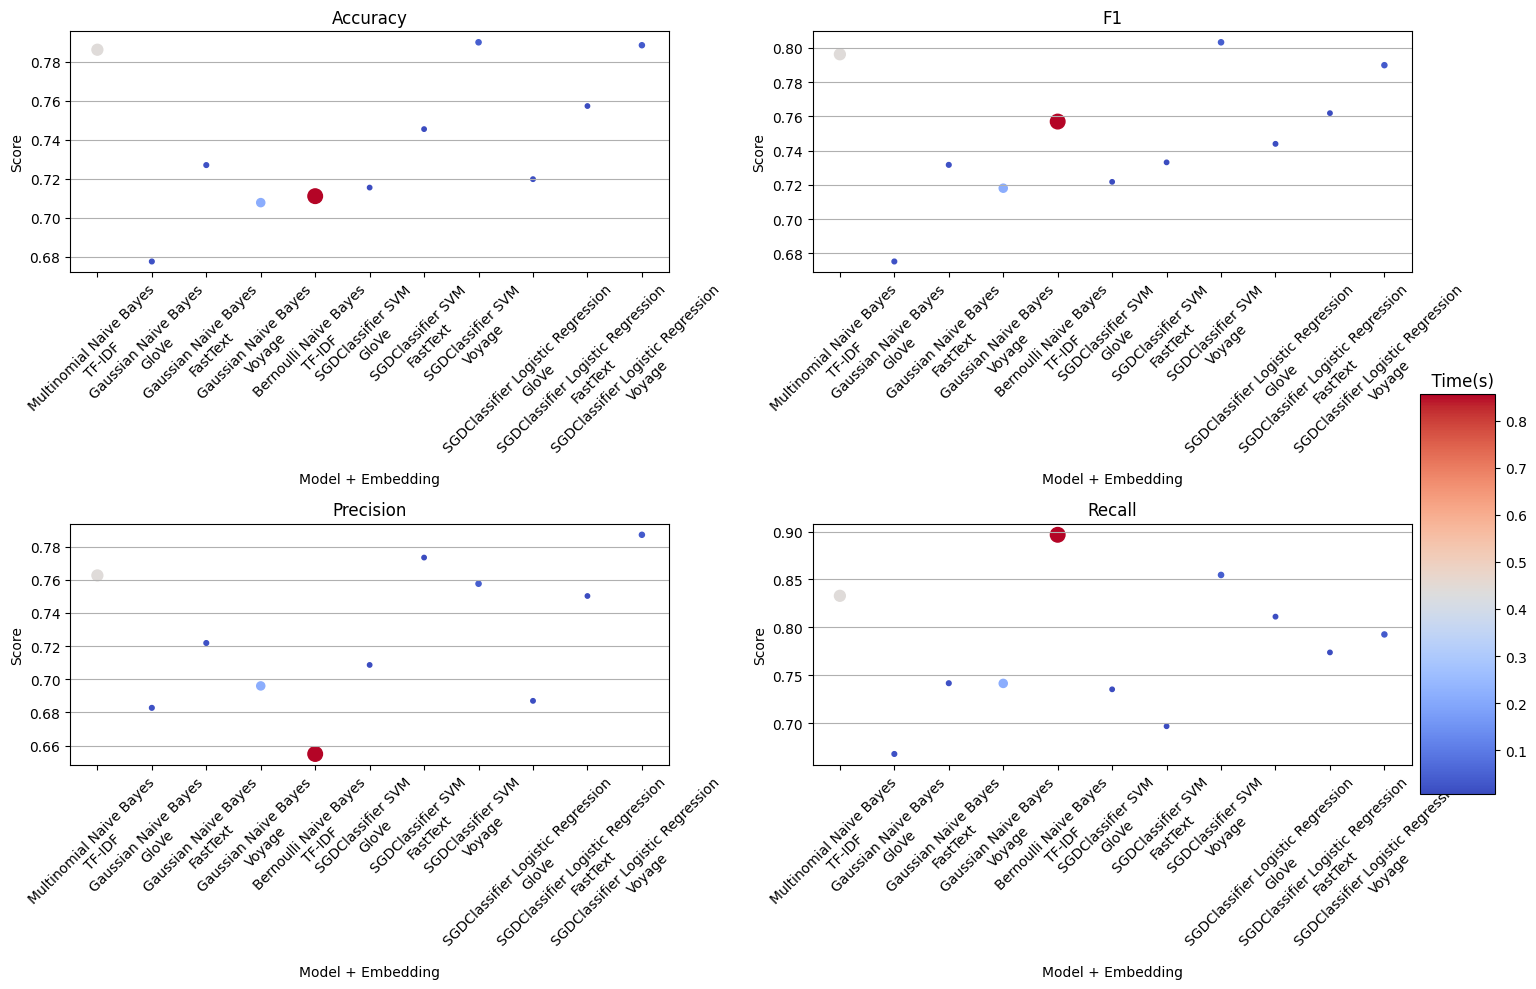

In [ ]:
plot_scores(model_scores, 'images/lr_scores.png')

### We find rather similar results to the `SVM`. However, the precision is significantly higher with `LogisticRegression` for `Voyage`

In [ ]:
with open('model_scores.json', 'w') as f:
    json.dump(model_scores, f)

### We will now use `FastText` not as an embedding model but a complete model

#### we will first recover our cleaned dataframe without the embedings

In [ ]:
df_train = pd.read_csv('data_train_cleaned.csv')
df_test = pd.read_csv('data_test_cleaned.csv')
df_val = pd.read_csv('data_val_cleaned.csv')

In [ ]:
df_train.head()

,Content,Label
0,merg discuss slut merg discuss page ever held ...,0
1,dunno look okay like,0
2,ipak odustajem haha hahaha,0
3,moslem terrorist rather vigilant killer whale,1
4,meant claim fuck boi bwhahhahahaha,1


In [ ]:
def process_for_supervised_ft(df):
    df_bis = df.copy()
    df_bis['Label'] = '__label__' + df_bis['Label'].astype(str)
    df_bis['Content'] = df_bis['Label'] + ' ' + df_bis['Content']

    return df_bis[['Content']]

In [ ]:
df_train_ft = process_for_supervised_ft(df_train)
df_test_ft = process_for_supervised_ft(df_test)
df_val_ft = process_for_supervised_ft(df_val)

In [ ]:
df_train_ft.shape

(29956, 1)

In [ ]:
df_train_ft.to_csv('data_train_ft.train', index=False, header=False)
df_test_ft.to_csv('data_test_ft.test', index=False, header=False)
df_val_ft.to_csv('data_val_ft.val', index=False, header=False)

In [ ]:
ft = fasttext.train_supervised(input='data_train_ft.train', autotuneValidationFile='data_val_ft.val')

Progress: 100.0% Trials:   11 Best score:  0.797276 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  28216
Number of labels: 2
Progress: 100.0% words/sec/thread:  513738 lr:  0.000000 avg.loss:  0.072306 ETA:   0h 0m 0s


#### Now let's benchmark the model, and store in the `model_scores.json`.

In [ ]:
with open('model_scores.json', 'r') as f:
    model_scores = json.load(f)

In [ ]:
print(json.dumps(model_scores, indent=4)[:600])

{
    "Multinomial Naive Bayes": {
        "GloVe": {},
        "FastText": {},
        "Voyage": {},
        "TF-IDF": {
            "accuracy": 0.7861219585461099,
            "f1": 0.7962609690957649,
            "precision": 0.7626530239356842,
            "recall": 0.8329674715625623,
            "time": 0.44068196100124624
        }
    },
    "Gaussian Naive Bayes": {
        "GloVe": {
            "accuracy": 0.6776809852808652,
            "f1": 0.675274891556542,
            "precision": 0.6827825377396981,
            "recall": 0.6679305527838755,
            "time": 0.0178534029982


In [ ]:
start = perf_counter()
preds = ft.predict(df_test_ft['Content'].tolist())
end = perf_counter() - start

preds = [int(pred[0][-1]) for pred in preds[0]]

ft_accuracy = accuracy_score(df_test['Label'], preds)
ft_f1 = f1_score(df_test['Label'], preds)
ft_precision = precision_score(df_test['Label'], preds)
ft_recall = recall_score(df_test['Label'], preds)

model_scores['FastText Supervised'] = {
    'accuracy': ft_accuracy,
    'f1': ft_f1,
    'precision': ft_precision,
    'recall': ft_recall,
    'time': end
}

print('FastText Supervised Model Scores', end='\n\n')
print(f'Accuracy: {ft_accuracy}')
print(f'F1: {ft_f1}')
print(f'Precision: {ft_precision}')
print(f'Recall: {ft_recall}')
print(f'Inference Time: {end}')

FastText Supervised Model Scores

Accuracy: 0.7959347151296686
F1: 0.7950935049266037
Precision: 0.8012158054711246
Recall: 0.789064059070046
Inference Time: 0.24481110300985165


#### `FastText`'s scores are really not bad, it has the best accuracy so far, even surpassing Voyage-02 as feature extraction.

#### In order for the graphics to remain visible we will only select the most efficient models so far:  
* Multinomial Naive Bayes with TF-IDF  
* SGD Logistic Regression Voyage  
* SGD SVM Voyage

In [ ]:
# We keep only Multinomial Naive Bayes TFIDF, SGD Logidtic Regression Voyage, SGD SVM Voyage and FastText Supervised.

relevant_models = [('Multinomial Naive Bayes', 'TF-IDF'), ('SGDClassifier Logistic Regression', 'Voyage'), ('SGDClassifier SVM','Voyage')]

model_scores_relevant = {model: {embed:model_scores[model][embed]} for model, embed in relevant_models}

model_scores_relevant['FastText Supervised'] = {"" : model_scores['FastText Supervised']}

print(json.dumps(model_scores_relevant, indent=4))

{
    "Multinomial Naive Bayes": {
        "TF-IDF": {
            "accuracy": 0.7861219585461099,
            "f1": 0.7962609690957649,
            "precision": 0.7626530239356842,
            "recall": 0.8329674715625623,
            "time": 0.44068196100124624
        }
    },
    "SGDClassifier Logistic Regression": {
        "Voyage": {
            "accuracy": 0.7884249524381696,
            "f1": 0.7898975837724967,
            "precision": 0.7871581450653984,
            "recall": 0.7926561564557972,
            "time": 0.035293695000291336
        }
    },
    "SGDClassifier SVM": {
        "Voyage": {
            "accuracy": 0.7899269049764694,
            "f1": 0.8032633158289573,
            "precision": 0.7576508048823634,
            "recall": 0.8547196168429455,
            "time": 0.040090467999107204
        }
    },
    "FastText Supervised": {
        "": {
            "accuracy": 0.7959347151296686,
            "f1": 0.7950935049266037,
            "precision": 0.801

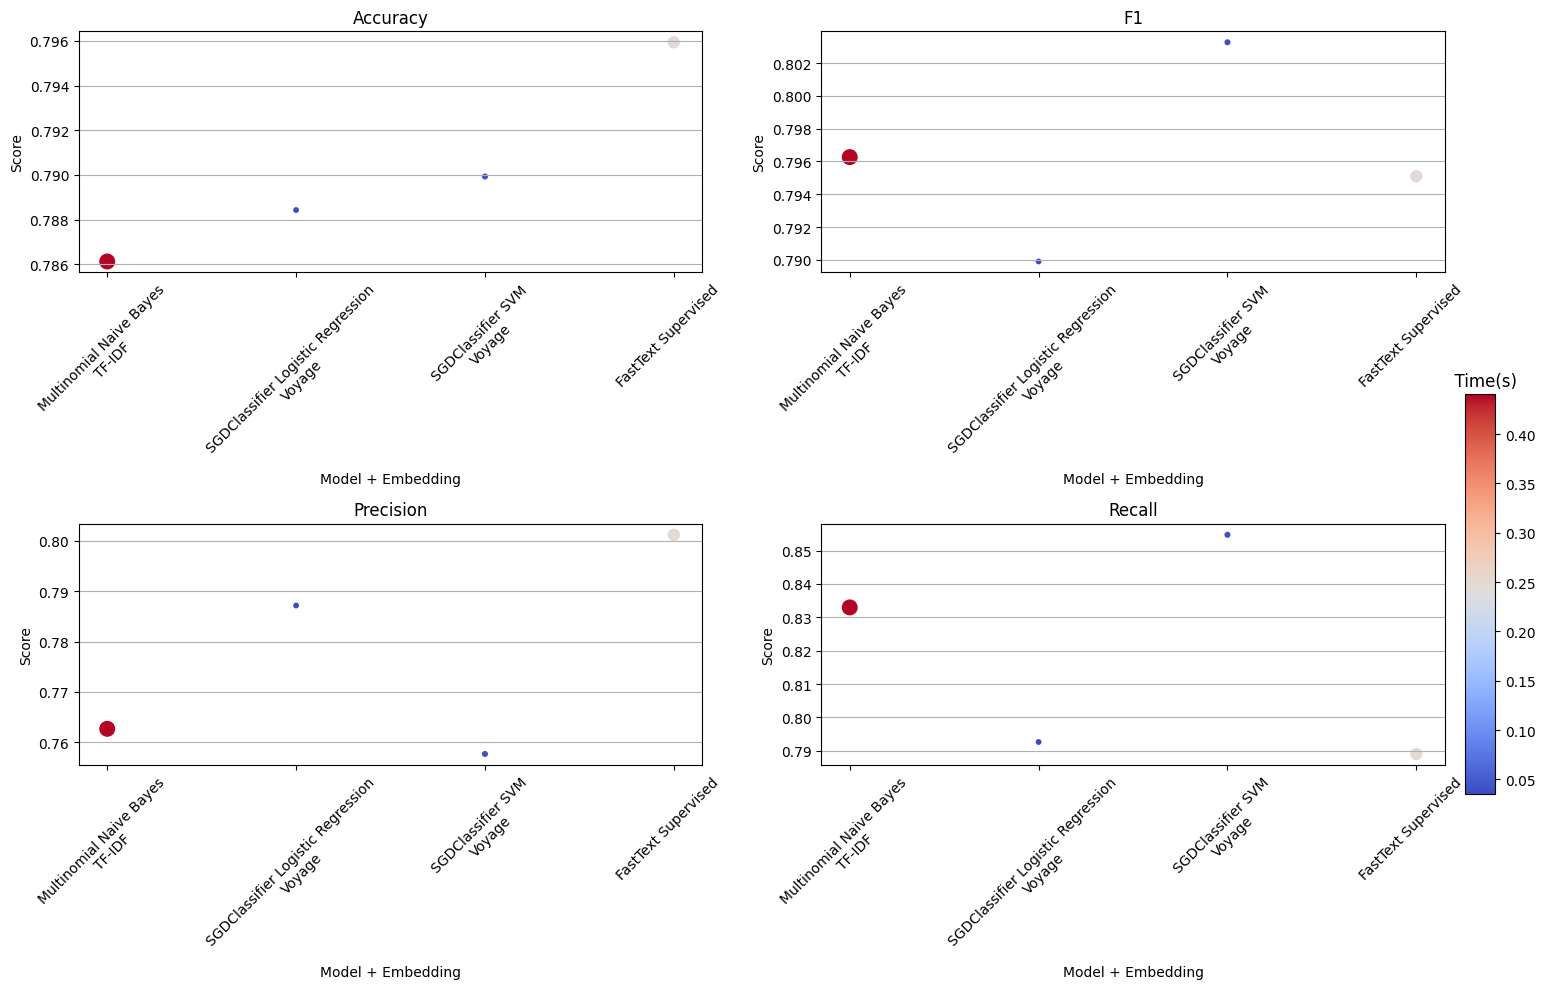

In [ ]:
plot_scores(model_scores_relevant, 'images/relevant_models_scores.png')

### We notice here that `FastText` outperformed the best models in terms of accuracy and precision. However, regarding recall the model is not very good compared to the others, implying that it is only second in terms of f1 score. These observations show us that the model is very interesting, particularly if we want to be sure to filter as many negative comments as possible.

In [58]:
model_scores.update(model_scores_relevant['FastText Supervised'])

In [ ]:
with open('model_scores.json', 'w') as f:
    json.dump(model_scores, f)

## In the rest of the notebook, I will need a GPU for training. We will use a Transformer of type Encoder for our classification task. So I'm going to import the notebook into [colab](https://colab.research.google.com/)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install -U datasets transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confli

In [3]:
from datasets import load_dataset, DatasetDict
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import torch
from time import perf_counter
from collections import Counter
import json
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [4]:
PARENT_PATH = "/content/drive/MyDrive/hate_speechs"
DATA_PATH = f"{PARENT_PATH}/data"
IMAGE_PATH = f"{PARENT_PATH}/images"

### We start with loading the data for training with the `load_dataset` function:

In [5]:
dataset = DatasetDict({
    "train" : load_dataset("csv", data_files=f"{DATA_PATH}/data_train.csv")["train"],
    "validation" : load_dataset("csv", data_files=f"{DATA_PATH}/data_val.csv")["train"],
    "test" : load_dataset("csv", data_files=f"{DATA_PATH}/data_test.csv")["train"]

 })

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['Content', 'Label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 10000
    })
})

### Next, we choose the model and build some usefull functions.

In [7]:
MODEL_NAME = "bert-base-uncased"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
def compute_metrics(pred):
  """
  compute the choosen metrics for our classification task.

  :param pred: The predictions
  """

  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds)
  acc = accuracy_score(labels, preds)
  precision = precision_score(labels, preds)
  recall = recall_score(labels, preds)
  return {"accuracy" : acc,
          "f1" : f1,
          "precision" : precision,
          "recall" : recall}

def tokenize(batch):
  return tokenizer(batch['Content'], padding=True, truncation=True, return_tensors='pt')

In [10]:
dataset_encoded = dataset.map(tokenize,
                              batched=True,
                              batch_size=None
                              )

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [11]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['Content', 'Label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['Content', 'Label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [12]:
for split in dataset_encoded.keys():
  dataset_encoded[split] = dataset_encoded[split].rename_column('Label', 'labels')
  dataset_encoded[split] = dataset_encoded[split].rename_column('Content', 'text')
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [ ]:
id2label = {
    0 : "Positive",
    1 : "Negative"
}

label2id = {
    "Positive" : 0,
    "Negative" : 1
}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
BATCH_SIZE = 64
LS = len(dataset_encoded["train"]) // BATCH_SIZE
OUTPUT_DIR = f"{MODEL_NAME}-finetuned-hs-od"

In [ ]:
training_args = TrainingArguments(output_dir = OUTPUT_DIR,
                                  num_train_epochs = 5,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=LS,
                                  push_to_hub=False,
                                  log_level="error",
                                  fp16=True
                                  )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.403300,0.352153,0.841300,0.831188,0.891806,0.778287
2,0.261700,0.342130,0.855600,0.850487,0.885511,0.818127
3,0.163800,0.376624,0.857700,0.852371,0.889370,0.818327
4,0.103800,0.448520,0.857600,0.852313,0.889009,0.818526
5,0.070400,0.550637,0.856200,0.849896,0.892763,0.810956


TrainOutput(global_step=2345, training_loss=0.20030118488807921, metrics={'train_runtime': 1092.9856, 'train_samples_per_second': 137.239, 'train_steps_per_second': 2.145, 'total_flos': 3.9466658304e+16, 'train_loss': 0.20030118488807921, 'epoch': 5.0})

In [ ]:
trainer.save_model()

In [ ]:
!cp -r /content/bert-base-uncased-finetuned-hs-od /content/drive/MyDrive/hate_speechs

### Now we'll benchmark our model

In [14]:
from torch.utils.data import DataLoader

In [15]:
data_test = DataLoader(dataset_encoded["test"], batch_size=64, shuffle=False)

In [18]:
device ="cuda" if torch.cuda.is_available() else "cpu"

In [19]:
# We choose our best checkpoint acording to the metrics (not only the loss)

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/hate_speechs/bert-base-uncased-finetuned-hs-od/checkpoint-1500")

In [20]:
device

'cuda'

In [21]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [49]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=64,
    dataloader_drop_last=False,
    do_predict=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
)

In [ ]:
test_results = trainer.evaluate(dataset_encoded["test"])

In [51]:
test_results

{'eval_loss': 0.4510648846626282,
 'eval_accuracy': 0.8612,
 'eval_f1': 0.8597413096200485,
 'eval_precision': 0.872436423297785,
 'eval_recall': 0.8474103585657371,
 'eval_runtime': 348.7659,
 'eval_samples_per_second': 28.673,
 'eval_steps_per_second': 0.45}

In [61]:
import json

with open(f"{DATA_PATH}/model_scores.json", 'r') as f:
  model_scores = json.load(f)

In [63]:
model_scores['Multinomial Naive Bayes']['TF-IDF']

{'accuracy': 0.7861219585461099,
 'f1': 0.7962609690957649,
 'precision': 0.7626530239356842,
 'recall': 0.8329674715625623,
 'time': 0.44068196100124624}

In [65]:
model_scores["BERT"] = {"": {
    "accuracy": test_results["eval_accuracy"],
    "f1": test_results["eval_f1"],
    "precision": test_results["eval_precision"],
    "recall": test_results["eval_recall"],
    "time": test_results["eval_runtime"]
}}

In [66]:
model_scores["BERT"]

{'': {'accuracy': 0.8612,
  'f1': 0.8597413096200485,
  'precision': 0.872436423297785,
  'recall': 0.8474103585657371,
  'time': 348.7659}}

In [70]:
model_scores.keys()

dict_keys(['Multinomial Naive Bayes', 'Gaussian Naive Bayes', 'Bernoulli Naive Bayes', 'SGDClassifier SVM', 'SGDClassifier Logistic Regression', 'FastText Supervised', 'BERT'])

In [72]:
relevant_models = [("Multinomial Naive Bayes", "TF-IDF"), ("SGDClassifier SVM", "Voyage"), ("FastText Supervised", ""), ("BERT", "")]
model_scores_relevant = {model: {embed:model_scores[model][embed]} for model, embed in relevant_models}

In [73]:
model_scores_relevant

{'Multinomial Naive Bayes': {'TF-IDF': {'accuracy': 0.7861219585461099,
   'f1': 0.7962609690957649,
   'precision': 0.7626530239356842,
   'recall': 0.8329674715625623,
   'time': 0.44068196100124624}},
 'SGDClassifier SVM': {'Voyage': {'accuracy': 0.7899269049764694,
   'f1': 0.8032633158289573,
   'precision': 0.7576508048823634,
   'recall': 0.8547196168429455,
   'time': 0.040090467999107204}},
 'FastText Supervised': {'': {'accuracy': 0.7959347151296686,
   'f1': 0.7950935049266037,
   'precision': 0.8012158054711246,
   'recall': 0.789064059070046,
   'time': 0.24481110300985165}},
 'BERT': {'': {'accuracy': 0.8612,
   'f1': 0.8597413096200485,
   'precision': 0.872436423297785,
   'recall': 0.8474103585657371,
   'time': 348.7659}}}

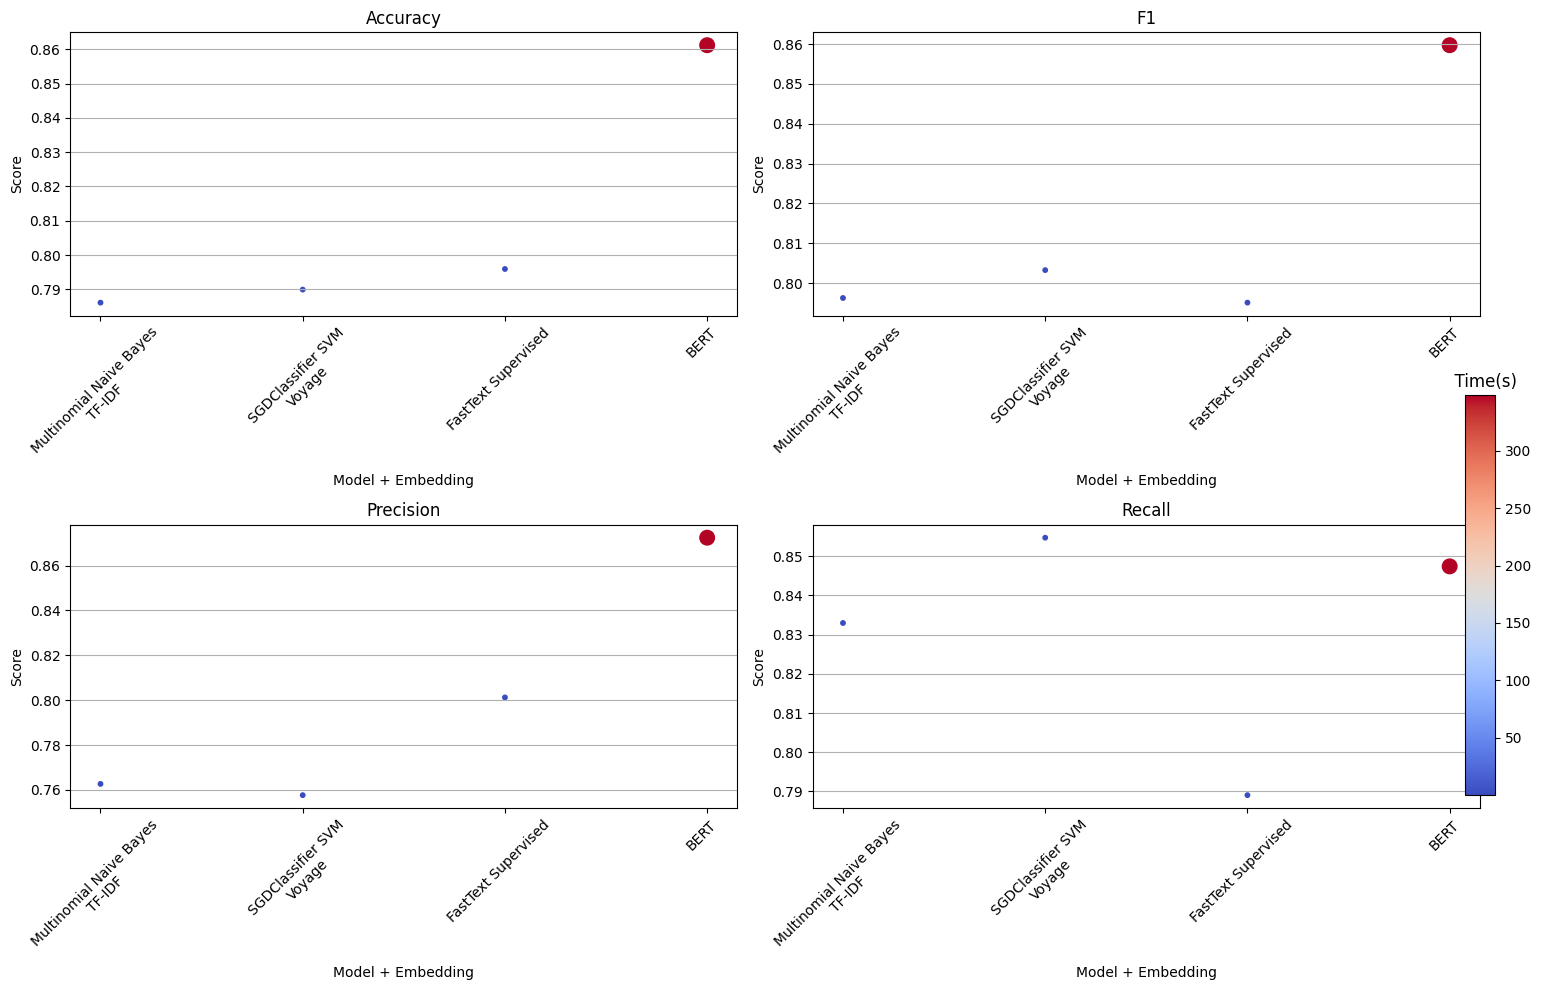

In [76]:
import matplotlib.pyplot as plt

plot_scores(model_scores_relevant, f"{IMAGE_PATH}/bert.png")

### The model has oubviously the bests performances but the inference time is critically higher than the others

## Dynamic Quantization

In [85]:
pip install -U optimum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.8/407.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.5 MB/s eta 0:00:00


In [89]:
pip install -U onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.1 MB/s eta 0:00:00
